In [229]:
import numpy as np
import pandas as pd
import pickle
import math

import scipy.interpolate

In [4]:
pkls_active_torchvision = !ls ./experiments/active_torchvision/*/*.pkl
pkls_projections = !ls ./experiments/projections/*/*.pkl
pkls = pkls_active_torchvision + pkls_projections
pkls

['./experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_1000_labeled_1000_budget_16000_seed_1231212.pkl',
 './experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_1000_labeled_1000_budget_16000_seed_2139843534.pkl',
 './experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_1000_labeled_1000_budget_16000_seed_9438745.pkl',
 './experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_1000_labeled_5000_budget_12000_seed_1231212.pkl',
 './experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_1000_labeled_5000_budget_12000_seed_2139843534.pkl',
 './experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_1000_labeled_5000_budget_12000_seed_9438745.pkl',
 './experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_125_labeled_1000_budget_16000_seed_1231212.pkl',
 './experiments/active_torchvision/cifar10/acq_bald_cs_argmax_batch_125_labeled_1000_budget_16000_seed_2139843534.pkl',
 './experiments/active_torchvision/cifar10/acq_ba

In [279]:
loaded_pkls = []
for pkl in pkls:
    # A file path looks like ./experiments/active_torchvision/svhn/acq_softrankbald_cs_stochastic_batch_500_labeled_3000_budget_4000_seed_9438745.pkl
    # Extract the dataset from pkl (svhn)
    dataset = pkl.split("/")[-2]
    # Split off the file name
    filename = pkl.split("/")[-1]
    if "labeled" not in filename:
        continue
    if "gamma" in filename:
        # filename is ./experiments/projections/cifar10/acq_proj_cs_fw_batch_4000_labeled_1000_gamma_07_budget_12000_seed_1231212.pkl
        # the pattern is acq_{acq_function}_cs_{selection_method}_batch_{batch_size}_labeled_{labeled}_gamma_{gamma}_budget_{active_budget}_seed_{seed}.pkl
        _, acq_function, _, selection_method, _, batch_size, _, initial_size, _, gamma, _, active_budget, _, seed = filename.split('.')[0].split('_')
    else:
        # filename is acq_softrankbald_cs_stochastic_batch_500_labeled_3000_budget_4000_seed_9438745.pkl
        # the pattern is acq_{acq_function}_cs_{selection_method}_batch_{batch_size}_labeled_{initial_size}_budget_{active_budget}_seed_{seed}.pkl
        _, acq_function, _, selection_method, _, batch_size, _, initial_size, _, active_budget, _, seed = filename.split('.')[0].split('_')

    with open(pkl, "br") as file:
        key = dict(
            filename=filename,
            dataset=dataset,
            acq_function=acq_function,
            selection_method=selection_method,
            batch_size=int(batch_size),
            active_budget=int(active_budget),
            initial_size=int(initial_size),
            seed=int(seed)
        )
        loaded_pkls.append((key, pickle.load(file)))

In [390]:
# For each experiment (each entry in loaded_pkls), we want to interpolate num_samples and Acc
for (key, exp_values) in loaded_pkls:
    for label, values in exp_values.items():
        # print(values)
        active_budget = key['active_budget']
        batch_size = key['batch_size']
        acc = values['Acc']
        num_samples = values['num_samples']
        
        interp_samples = np.linspace(0, active_budget, active_budget//batch_size + 1, endpoint=True)
        interp_acc = scipy.interpolate.interp1d(num_samples, acc, kind='quadratic')(interp_samples)
        
        interp_training_set_size = [key['initial_size'] + interp_sample for interp_sample in interp_samples]
        
        values['interp_samples'] = interp_samples.tolist()
        values['interp_acc'] = interp_acc.tolist()
        values['interp_training_set_size'] = interp_training_set_size
        # print(values)
    

In [391]:
[(key, label, value['Acc'][-1]) for key, result in loaded_pkls for label, value in result.items()]

[({'filename': 'acq_bald_cs_argmax_batch_1000_labeled_1000_budget_16000_seed_1231212.pkl',
   'dataset': 'cifar10',
   'acq_function': 'bald',
   'selection_method': 'argmax',
   'batch_size': 1000,
   'active_budget': 16000,
   'initial_size': 1000,
   'seed': 1231212},
  'BALD Argmax (M=1000)',
  0.7872178819444444),
 ({'filename': 'acq_bald_cs_argmax_batch_1000_labeled_1000_budget_16000_seed_2139843534.pkl',
   'dataset': 'cifar10',
   'acq_function': 'bald',
   'selection_method': 'argmax',
   'batch_size': 1000,
   'active_budget': 16000,
   'initial_size': 1000,
   'seed': 2139843534},
  'BALD Argmax (M=1000)',
  0.8060980902777778),
 ({'filename': 'acq_bald_cs_argmax_batch_1000_labeled_1000_budget_16000_seed_9438745.pkl',
   'dataset': 'cifar10',
   'acq_function': 'bald',
   'selection_method': 'argmax',
   'batch_size': 1000,
   'active_budget': 16000,
   'initial_size': 1000,
   'seed': 9438745},
  'BALD Argmax (M=1000)',
  0.8001302083333334),
 ({'filename': 'acq_bald_cs_arg

In [392]:
loaded_pkls[0]

({'filename': 'acq_bald_cs_argmax_batch_1000_labeled_1000_budget_16000_seed_1231212.pkl',
  'dataset': 'cifar10',
  'acq_function': 'bald',
  'selection_method': 'argmax',
  'batch_size': 1000,
  'active_budget': 16000,
  'initial_size': 1000,
  'seed': 1231212},
 {'BALD Argmax (M=1000)': {'LL': [3.820821656121148,
    3.188099834654066,
    2.7056925296783447,
    2.355988714430067,
    2.1975766817728677,
    2.0813390811284385,
    2.0442890988455877,
    1.9534320169024997,
    1.8405303292804294,
    1.763101061185201,
    1.757780498928494,
    1.7124470074971516,
    1.6440761221779718,
    1.5978346003426447,
    1.544978380203247,
    1.5062420500649347,
    1.4807084136539035],
   'Acc': [0.4776475694444444,
    0.5482855902777778,
    0.5891927083333334,
    0.6287977430555556,
    0.65234375,
    0.6723090277777778,
    0.6907552083333334,
    0.701171875,
    0.7253689236111112,
    0.7388237847222222,
    0.7454427083333334,
    0.7494574652777778,
    0.7611762152777778,

In [393]:
import pandas as pd

In [394]:
# Convert loaded_pkls to a dataframe
df = pd.DataFrame(
    [
        {
            **key,
            "label": label,
            **value
        }
        for key, result in loaded_pkls for label, value in result.items()
    ]
)

In [395]:
# Remove the last elements from each num_evals entry (which is a list)
df['num_evals'] = df['num_evals'].apply(lambda x: x[:-1])

In [396]:
df.columns

Index(['filename', 'dataset', 'acq_function', 'selection_method', 'batch_size',
       'active_budget', 'initial_size', 'seed', 'label', 'LL', 'Acc', 'ppos',
       'wt', 'num_samples', 'num_evals', 'init_num_labeled', 'train_idx',
       'interp_samples', 'interp_acc', 'interp_training_set_size'],
      dtype='object')

In [397]:
# turns out: num_samples varies... AFW does not acquire as many samples as it could??
# drop train_idx column
df = df.drop(columns=['train_idx', 'ppos'])

In [398]:
df

filename  dataset acq_function  \
0    acq_bald_cs_argmax_batch_1000_labeled_1000_bud...  cifar10         bald   
1    acq_bald_cs_argmax_batch_1000_labeled_1000_bud...  cifar10         bald   
2    acq_bald_cs_argmax_batch_1000_labeled_1000_bud...  cifar10         bald   
3    acq_bald_cs_argmax_batch_1000_labeled_5000_bud...  cifar10         bald   
4    acq_bald_cs_argmax_batch_1000_labeled_5000_bud...  cifar10         bald   
..                                                 ...      ...          ...   
678  acq_proj_cs_fw_batch_75_labeled_1000_gamma_07_...     svhn         proj   
679  acq_proj_cs_fw_batch_75_labeled_1000_gamma_07_...     svhn         proj   
680  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn         proj   
681  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn         proj   
682  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn         proj   

    selection_method  batch_size  active_budget  initial_size        seed  \
0             argmax        1000          16000          1000     1231212   
1             argmax        1000          16000          1000  2139843534   
2             argmax        1000          16000          1000     9438745   
3             argmax        1000          12000          5000     1231212   
4             argmax        1000          12000          5000  2139843534   
..               ...         ...            ...           ...         ...   
678               fw          75           6000          1000  2139843534   
679               fw          75           6000          1000     9438745   
680               fw          75           4000          3000     1231212   
681               fw          75           4000          3000  2139843534   
682               fw          75           4000          3000     9438745   

                           label  \
0           BALD Argmax (M=1000)   
1           BALD Argmax (M=1000)   
2           BALD Argmax (M=1000)   
3           BALD Argmax (M=1000)   
4           BALD Argmax (M=1000)   
..                           ...   
678  Proj FW (M=75, J=10, g=0.7)   
679  Proj FW (M=75, J=10, g=0.7)   
680  Proj FW (M=75, J=10, g=0.7)   
681  Proj FW (M=75, J=10, g=0.7)   
682  Proj FW (M=75, J=10, g=0.7)   

                                                    LL  \
0    [3.820821656121148, 3.188099834654066, 2.70569...   
1    [3.94671720928616, 3.123489591810438, 2.661789...   
2    [3.8612310886383057, 3.037504540549384, 2.6145...   
3    [1.6140085326300726, 1.6962994734446208, 1.615...   
4    [1.6671055290434096, 1.7000315056906805, 1.548...   
..                                                 ...   
678  [1.5235958480834961, 1.375641760826111, 1.2831...   
679  [1.7517973184585571, 1.5441932201385498, 1.372...   
680  [0.842174940109253, 0.8794941830635071, 0.8647...   
681  [0.7761001086235046, 0.7965680122375488, 0.804...   
682  [0.7871326279640197, 0.8223699188232422, 0.797...   

                                                   Acc  \
0    [0.4776475694444444, 0.5482855902777778, 0.589...   
1    [0.4714626736111111, 0.5512152777777778, 0.592...   
2    [0.4676649305555556, 0.5572916666666666, 0.606...   
3    [0.6606987847222222, 0.7105034722222222, 0.730...   
4    [0.6694878472222222, 0.7116970486111112, 0.742...   
..                                                 ...   
678  [0.745625, 0.778125, 0.7935546875, 0.804960937...   
679  [0.715234375, 0.7524609375, 0.7755078125, 0.78...   
680  [0.8326171875, 0.850546875, 0.856484375, 0.860...   
681  [0.840390625, 0.859609375, 0.8630859375, 0.874...   
682  [0.8409765625, 0.8552734375, 0.8637890625, 0.8...   

                                                    wt  \
0    [0.0, 131.57209873199463, 199.84890222549438, ...   
1    [0.0, 129.80736255645752, 197.74175572395325, ...   
2    [0.0, 130.79844999313354, 199.1720781326294, 2...   
3    [0.0, 155.95782136917114, 249.76084733009338, ...   
4    [0.0, 241.30448818206787, 379.35636973

In [399]:
#exploded_df = df.explode(['LL', 'Acc', 'wt', 'num_samples', 'num_evals'], ignore_index=True)
exploded_df = df.explode(['interp_samples', 'interp_acc', 'interp_training_set_size'], ignore_index=True)

In [400]:
exploded_df[exploded_df.selection_method=="fw"]

filename  dataset  \
17915  acq_proj_cs_fw_batch_1000_labeled_1000_gamma_0...  cifar10   
17916  acq_proj_cs_fw_batch_1000_labeled_1000_gamma_0...  cifar10   
17917  acq_proj_cs_fw_batch_1000_labeled_1000_gamma_0...  cifar10   
17918  acq_proj_cs_fw_batch_1000_labeled_1000_gamma_0...  cifar10   
17919  acq_proj_cs_fw_batch_1000_labeled_1000_gamma_0...  cifar10   
...                                                  ...      ...   
21498  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn   
21499  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn   
21500  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn   
21501  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn   
21502  acq_proj_cs_fw_batch_75_labeled_3000_gamma_07_...     svhn   

      acq_function selection_method  batch_size  active_budget  initial_size  \
17915         proj               fw        1000          16000          1000   
17916         proj               fw        1000          16000          1000   
17917         proj               fw        1000          16000          1000   
17918         proj               fw        1000          16000          1000   
17919         proj               fw        1000          16000          1000   
...            ...              ...         ...            ...           ...   
21498         proj               fw          75           4000          3000   
21499         proj               fw          75           4000          3000   
21500         proj               fw          75           4000          3000   
21501         proj               fw          75           4000          3000   
21502         proj               fw          75           4000          3000   

          seed                          label  \
17915  1231212  Proj FW (M=1000, J=10, g=0.7)   
17916  1231212  Proj FW (M=1000, J=10, g=0.7)   
17917  1231212  Proj FW (M=1000, J=10, g=0.7)   
17918  1231212  Proj FW (M=1000, J=10, g=0.7)   
17919  1231212  Proj FW (M=1000, J=10, g=0.7)   
...        ...                            ...   
21498  9438745    Proj FW (M=75, J=10, g=0.7)   
21499  9438745    Proj FW (M=75, J=10, g=0.7)   
21500  9438745    Proj FW (M=75, J=10, g=0.7)   
21501  9438745    Proj FW (M=75, J=10, g=0.7)   
21502  9438745    Proj FW (M=75, J=10, g=0.7)   

                                                      LL  \
17915  [3.8982675075531006, 3.3603956434461804, 3.000...   
17916  [3.8982675075531006, 3.3603956434461804, 3.000...   
17917  [3.8982675075531006, 3.3603956434461804, 3.000...   
17918  [3.8982675075531006, 3.3603956434461804, 3.000...   
17919  [3.8982675075531006, 3.3603956434461804, 3.000...   
...                                                  ...   
21498  [0.7871326279640197, 0.8223699188232422, 0.797...   
21499  [0.7871326279640197, 0.8223699188232422, 0.797...   
21500  [0.7871326279640197, 0.8223699188232422, 0.797...   
21501  [0.7871326279640197, 0.8223699188232422, 0.797...   
21502  [0.7871326279640197, 0.8223699188232422, 0.797...   

                                                     Acc  \
17915  [0.4692925347222222, 0.5251736111111112, 0.558...   
17916  [0.4692925347222222, 0.5251736111111112, 0.558...   
17917  [0.4692925347222222, 0.5251736111111112, 0.558...   
17918  [0.4692925347222222, 0.5251736111111112, 0.558...   
17919  [0.4692925347222222, 0.5251736111111112, 0.558...   
...                                                  ...   
21498  [0.8409765625, 0.8552734375, 0.8637890625, 0.8...   
21499  [0.8409765625, 0.8552734375, 0.8637890625, 0.8...   
21500  [0.8409765625, 0.8552734375, 0.8637890625, 0.8...   
21501  [0.8409765625, 0.8552734375, 0.8637890625, 0.8...   
21502  [0.8409765625, 0.8552734375, 0.8637890625, 0.8...   

                                                      wt  \
17915  [0.0, 137.10302329063416, 208.7139265537262, 2...   
17916  [0.0, 137.10302329063416, 208.7139265537262, 2...   
17917  [0.0, 137.10302329063416, 208.7139265537

In [401]:
del exploded_df['num_samples']
del exploded_df['Acc']
del exploded_df['num_evals']
del exploded_df['wt']
del exploded_df['LL']

In [402]:
# Create a new label based on the acq_function and selection_method
exploded_df['new_label'] = exploded_df['acq_function'] + '_' + exploded_df['selection_method']

In [403]:
# unique datasets
exploded_df['dataset'].unique()

array(['cifar10', 'fashion_mnist', 'repeated_mnist', 'svhn'], dtype=object)

In [404]:
import seaborn as sns

In [405]:
# Unique selection methods
exploded_df['new_label'].unique()

array(['bald_argmax', 'none_random', 'powerbald_stochastic',
       'softmaxbald_stochastic', 'softrankbald_stochastic', 'proj_fw'],
      dtype=object)

# PoC Visualizations

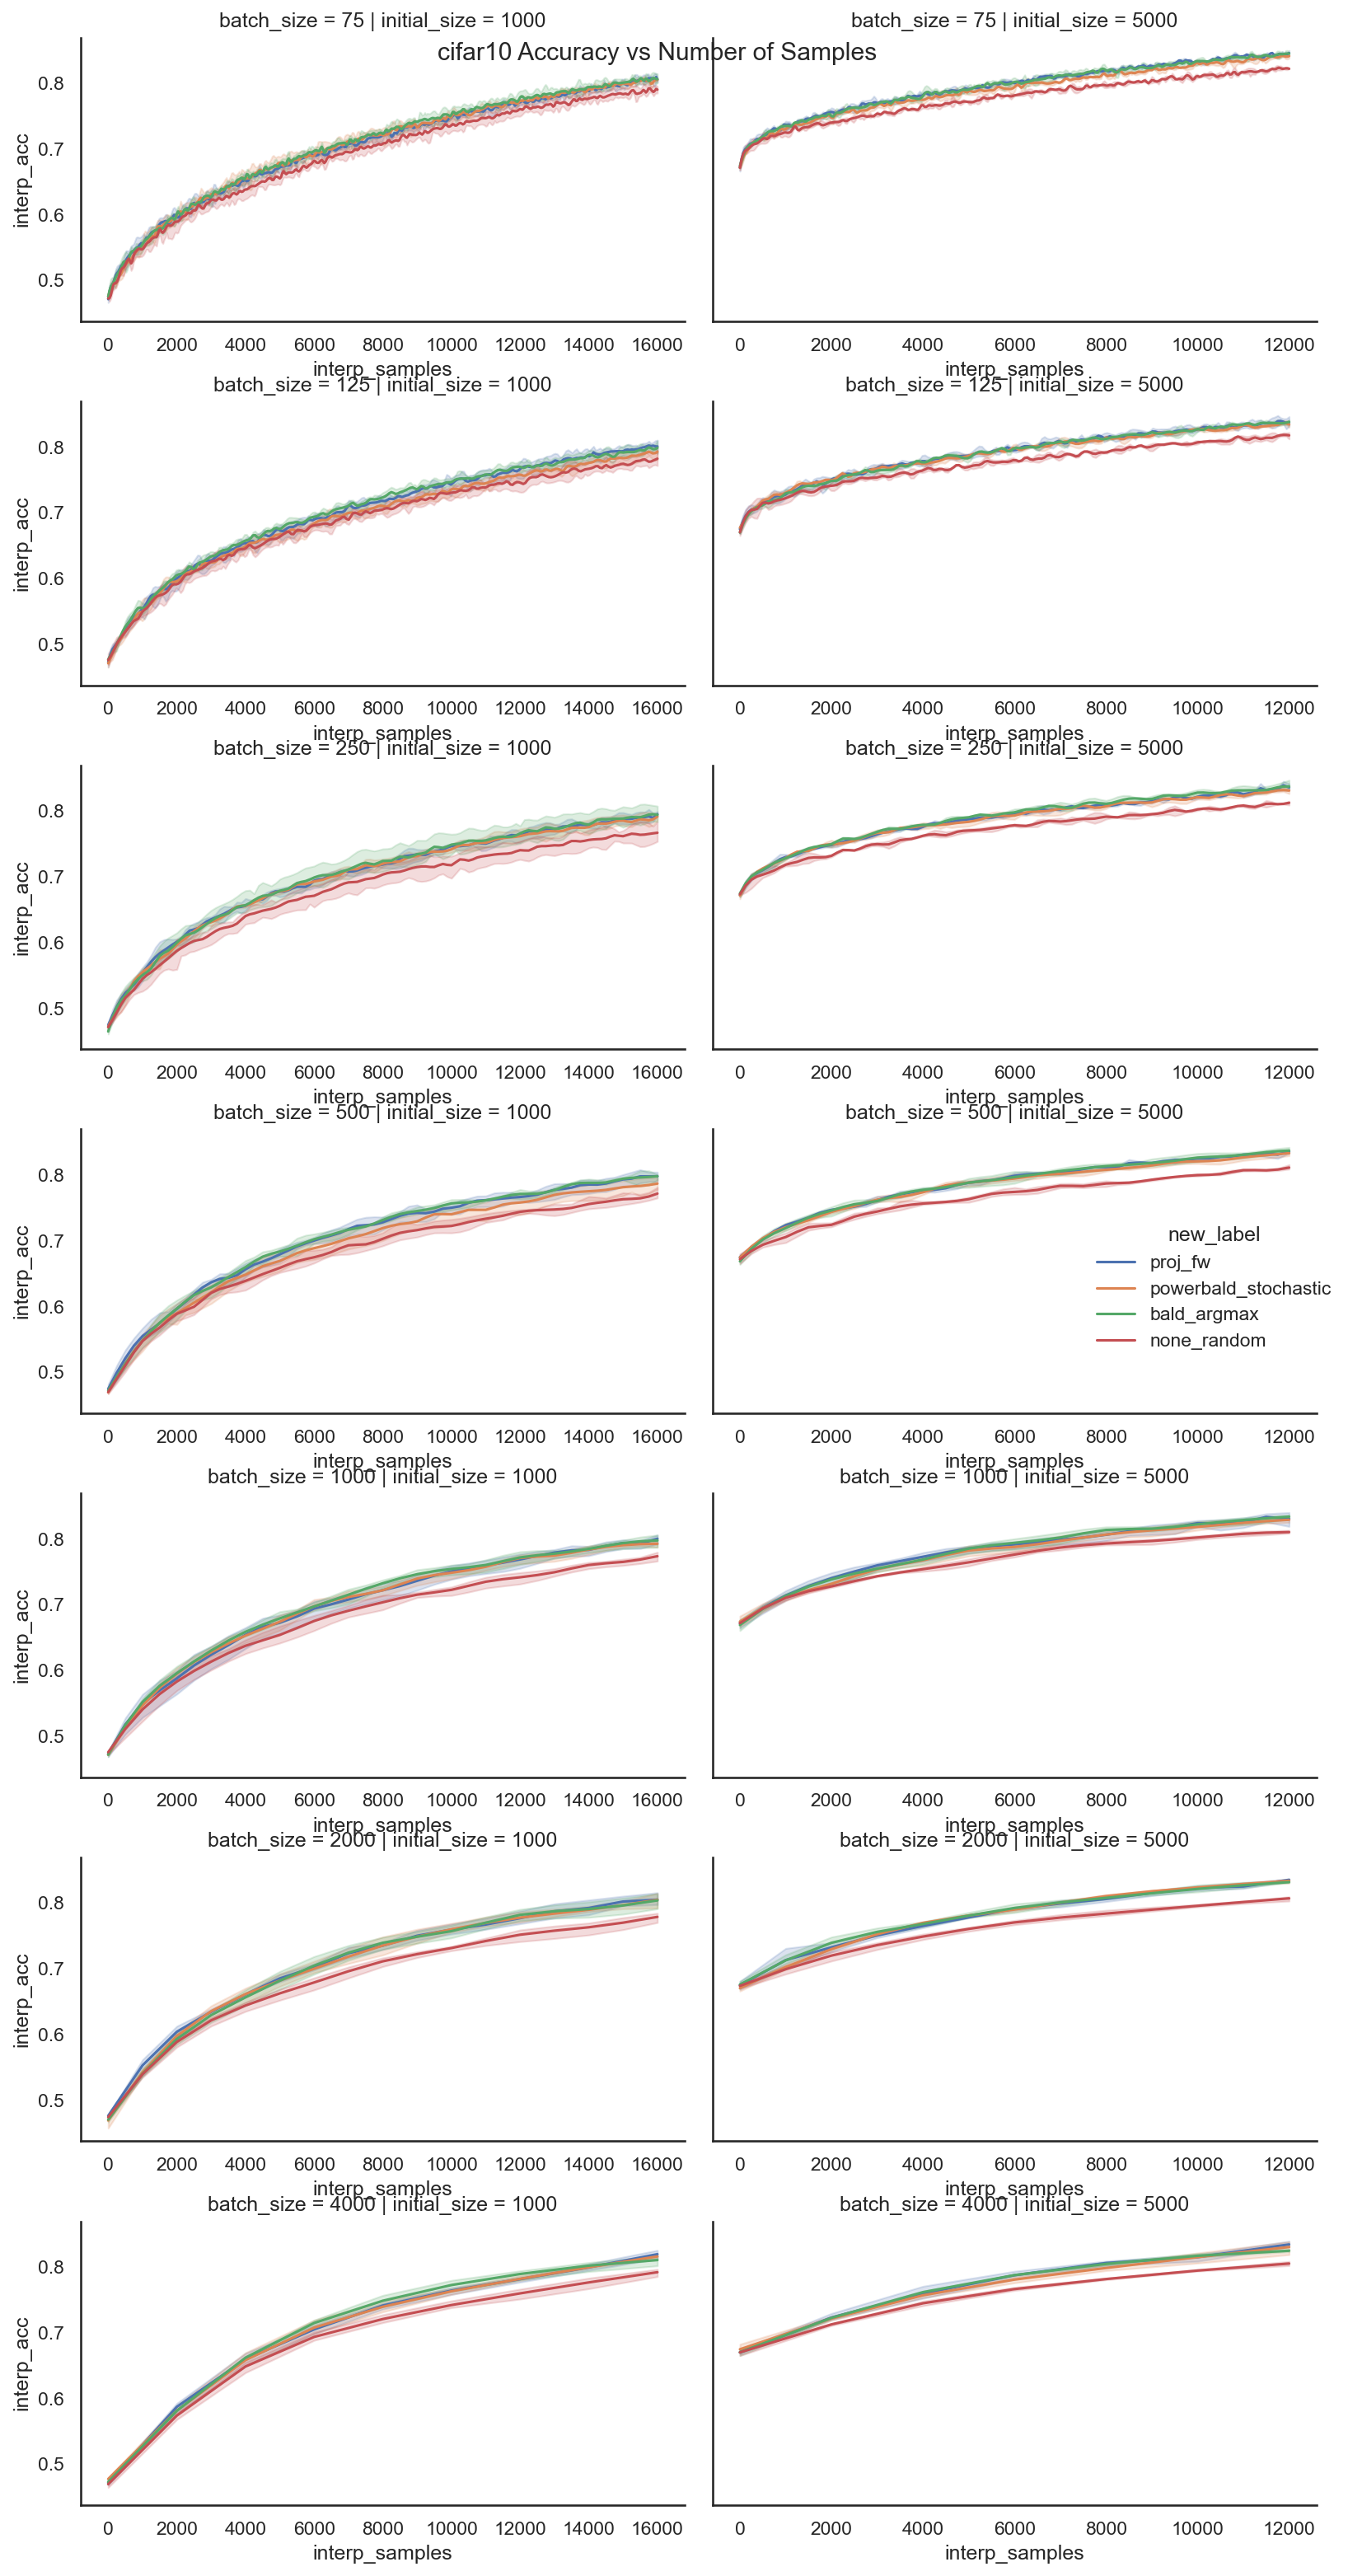

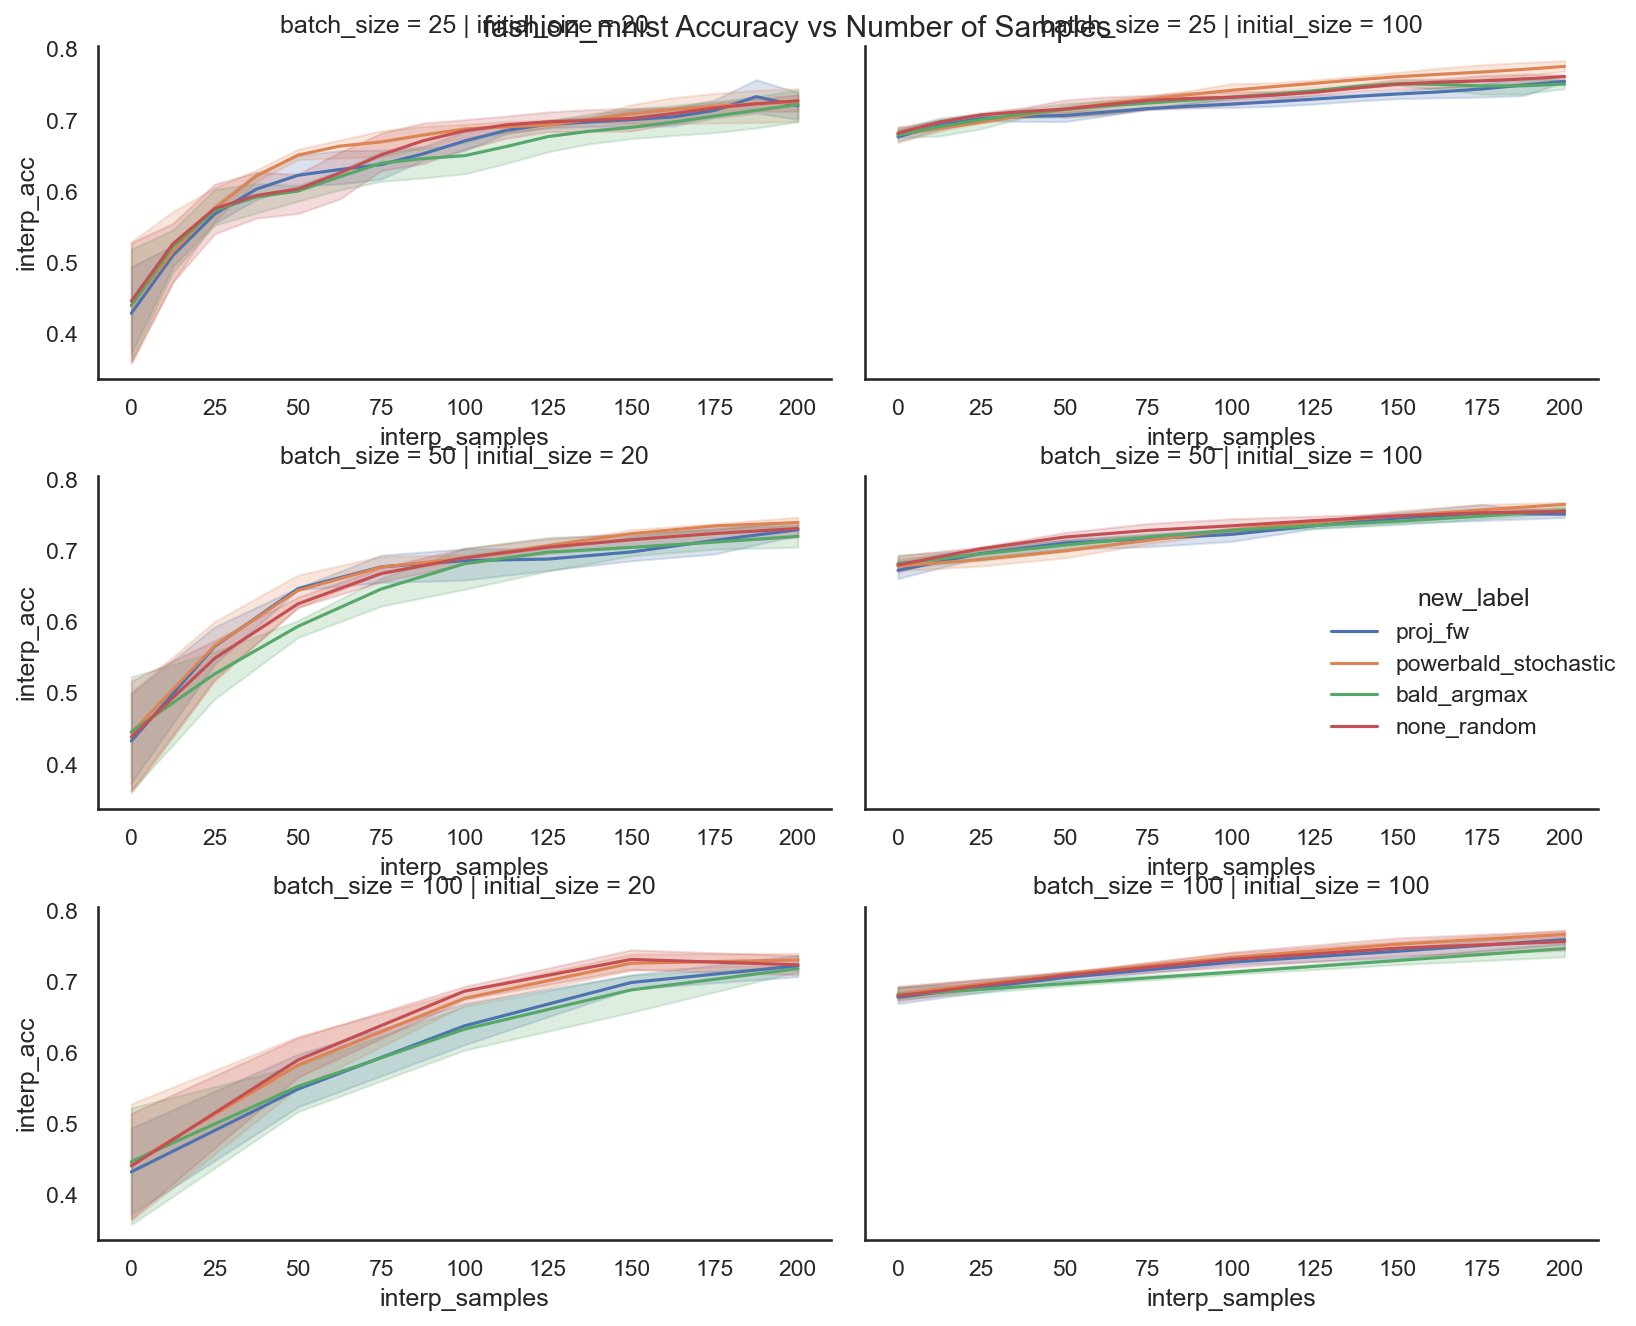

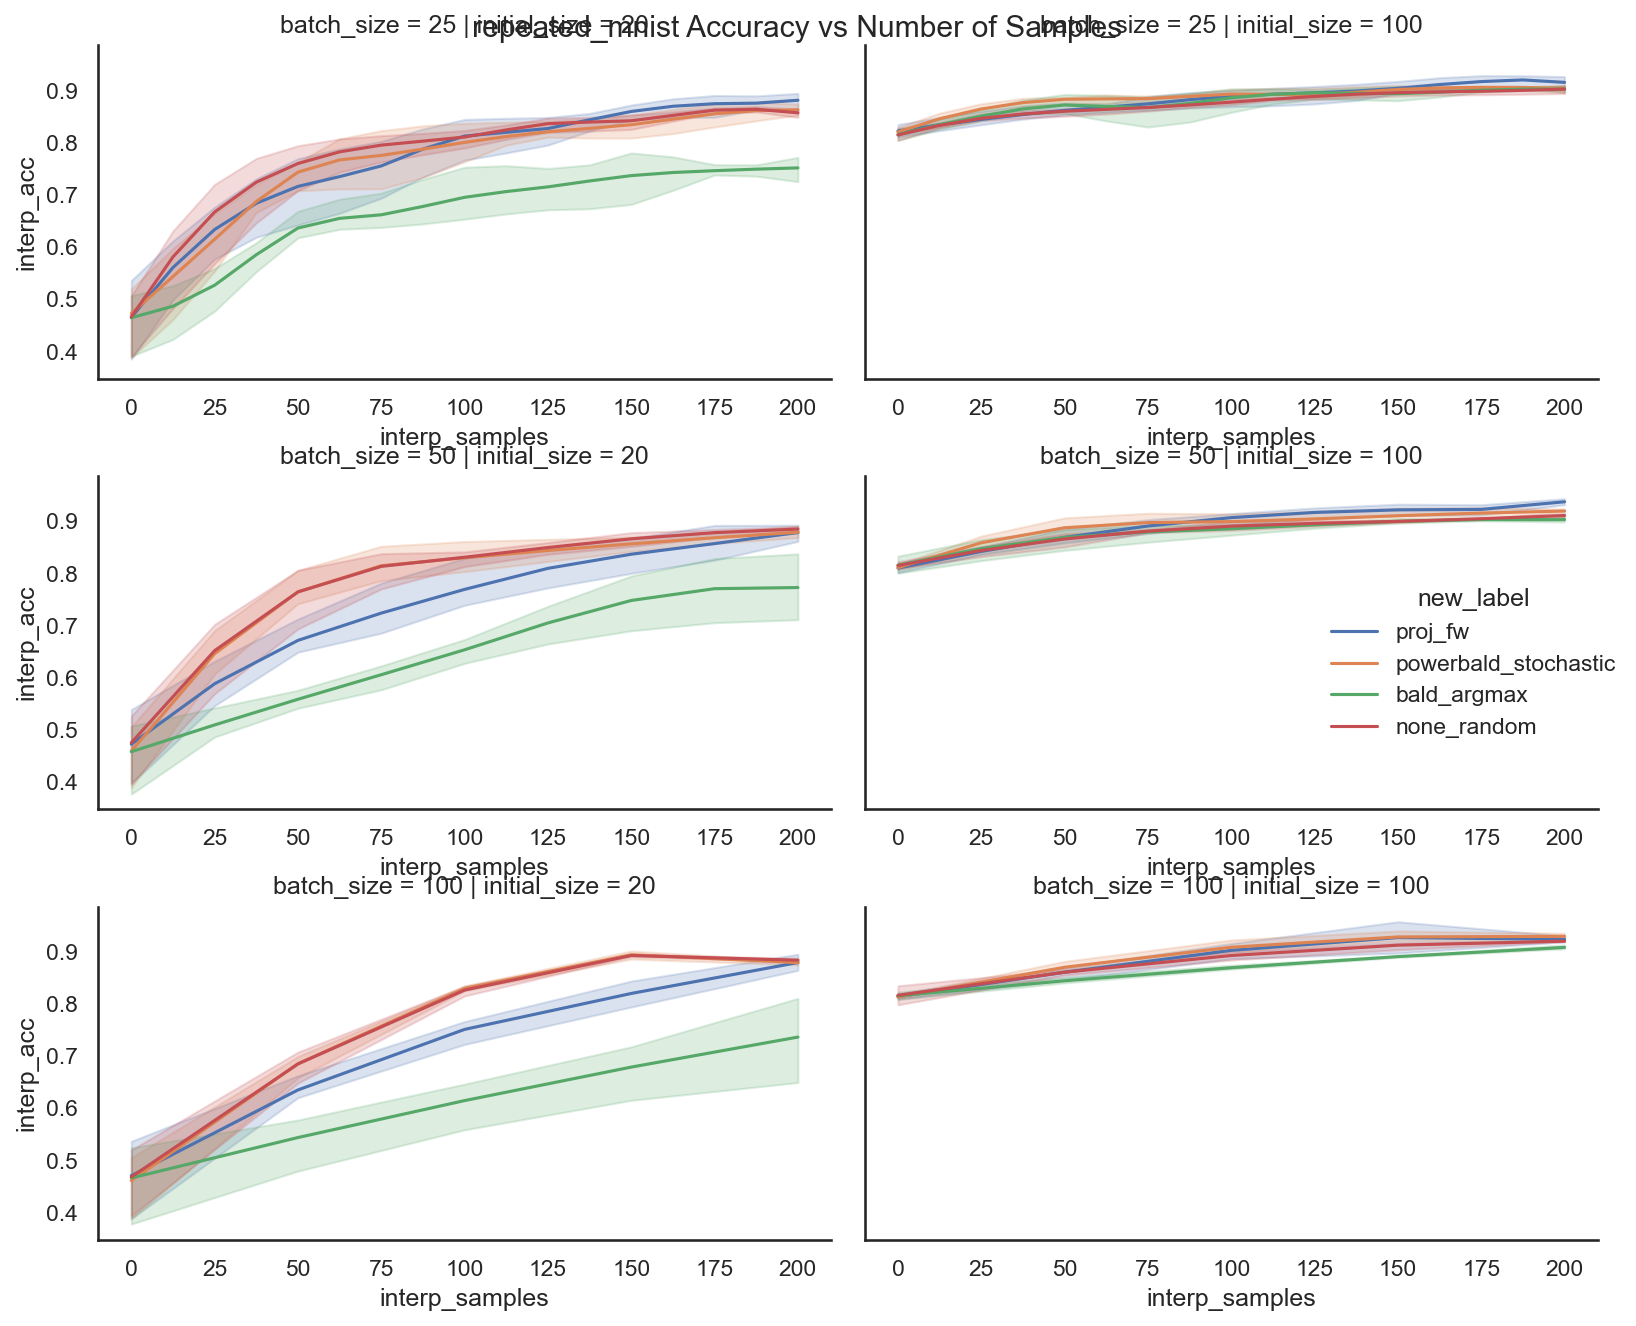

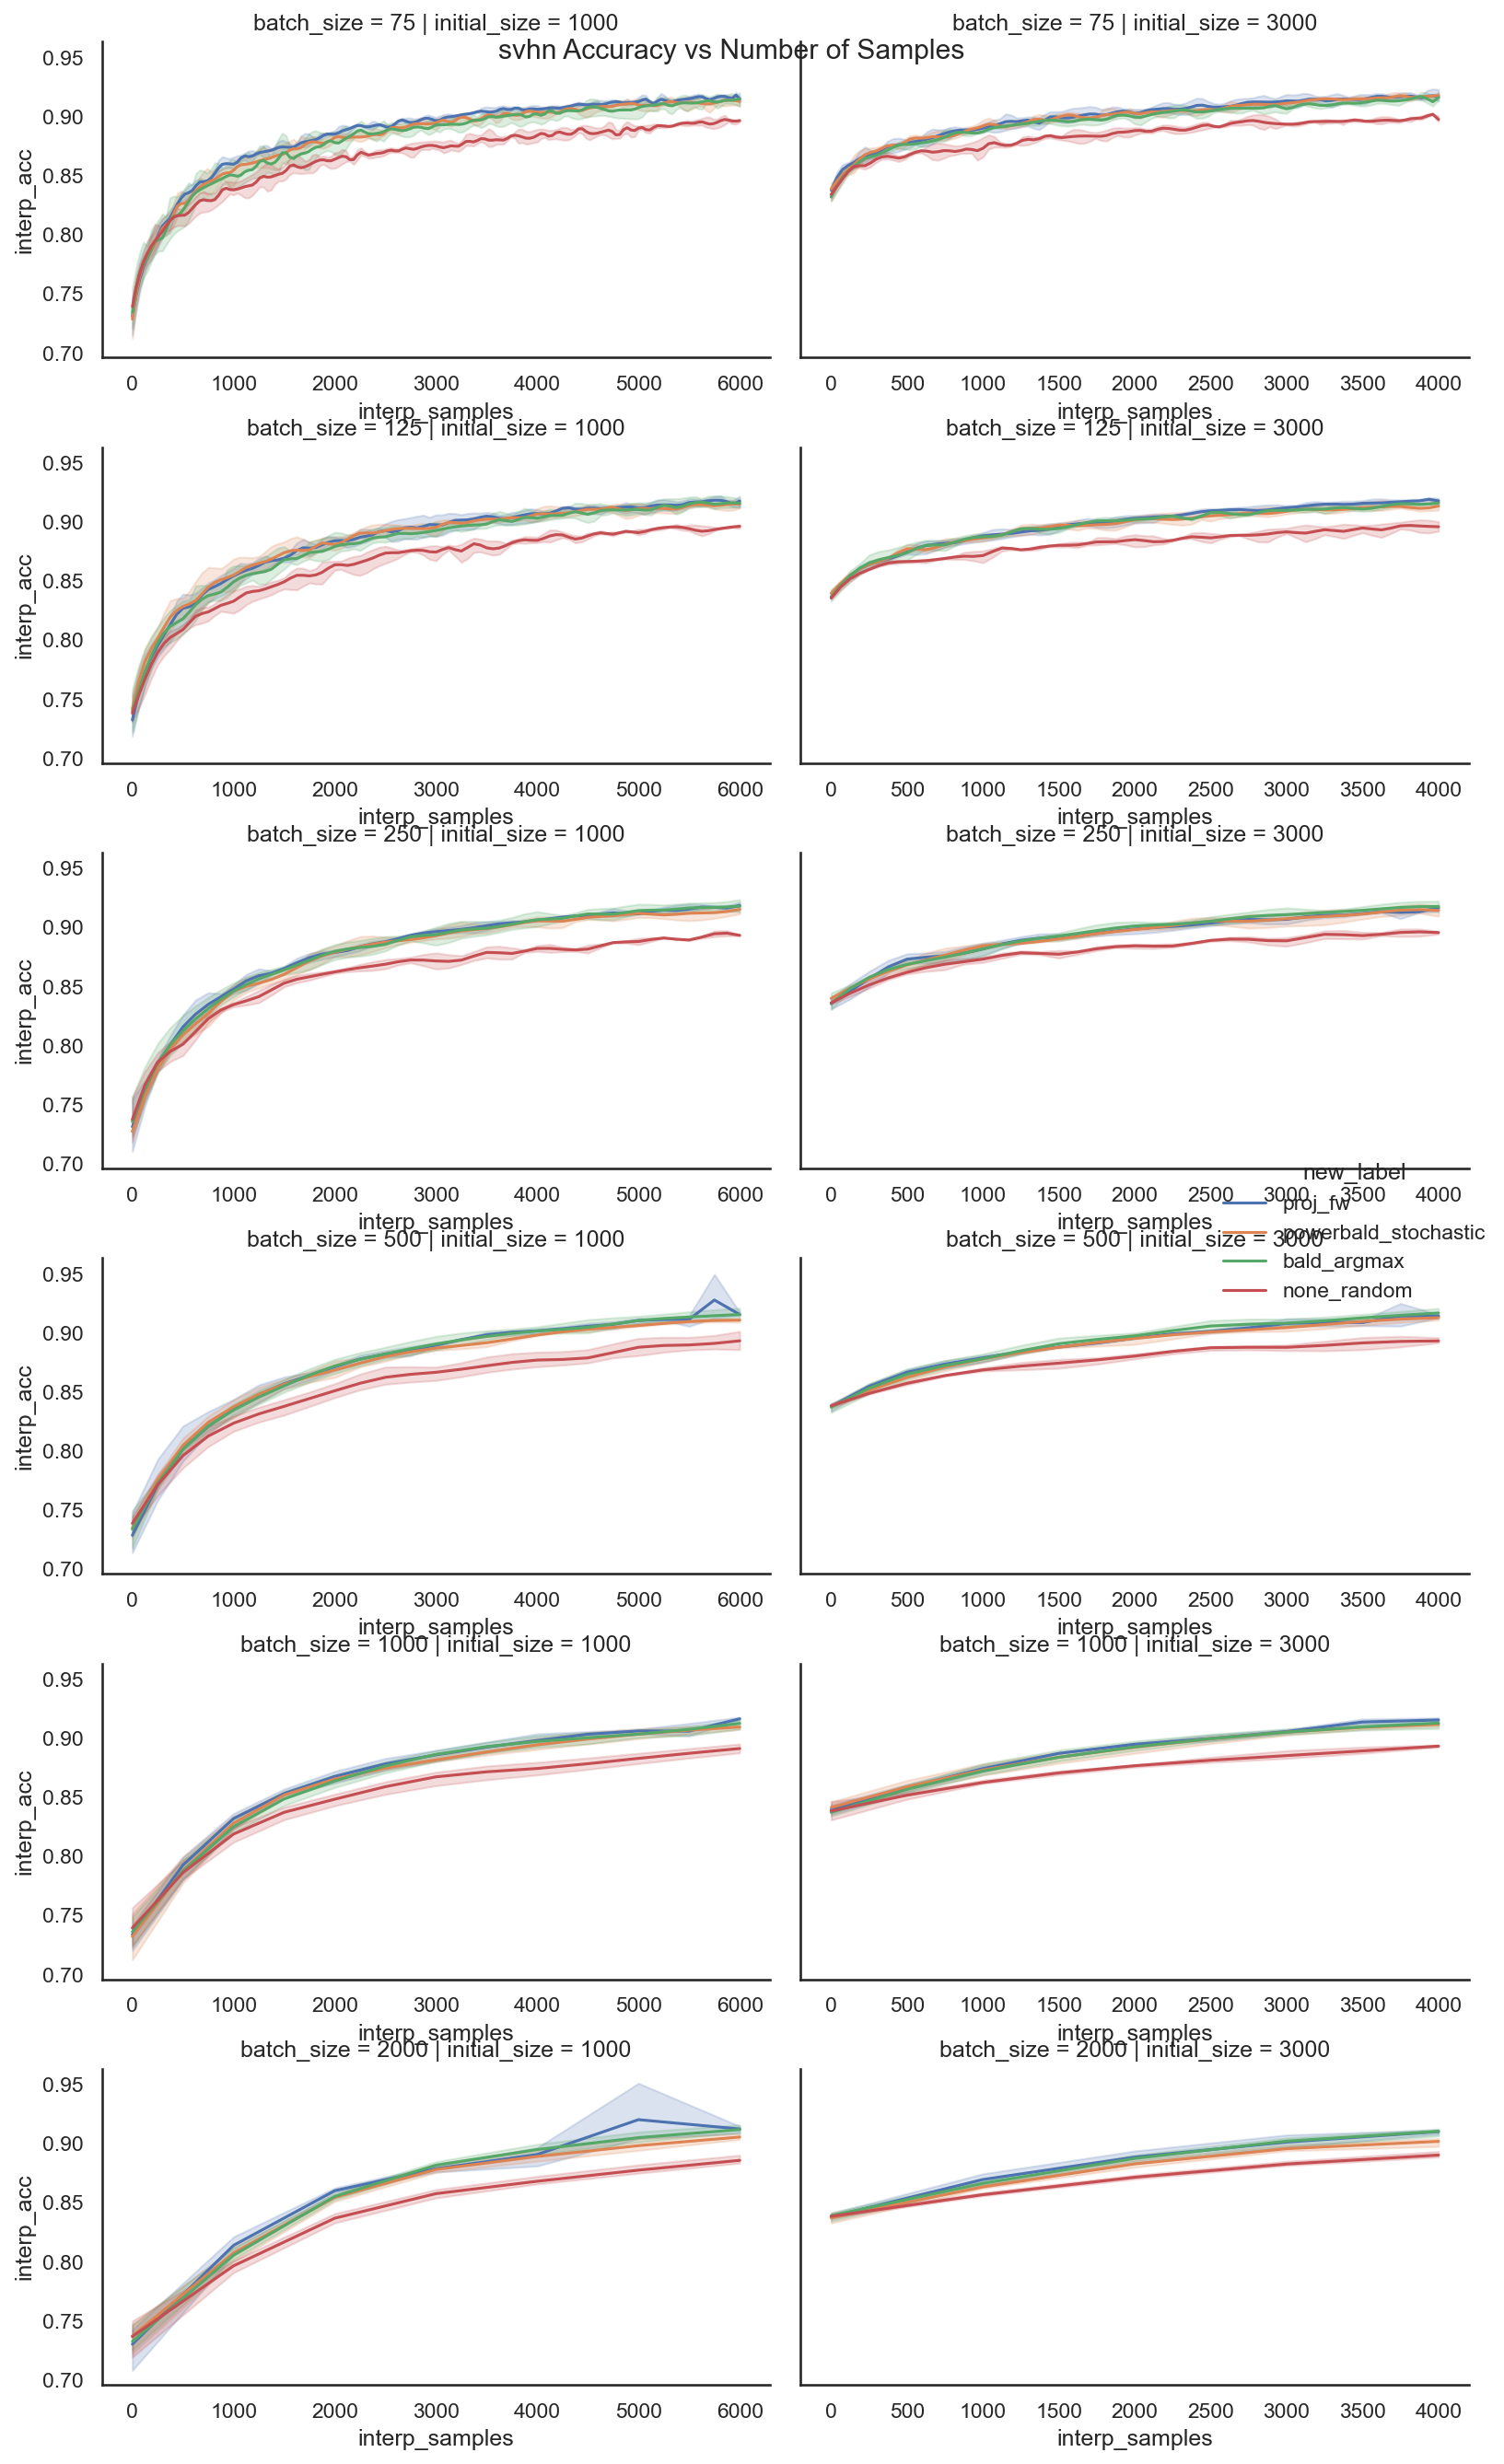

In [182]:
from matplotlib import pyplot as plt

# Plot cifar10 acc in a grid of plots by initial size and batch size
sns.set_theme(style="white")

# iterate over unique datasets
for dataset in exploded_df['dataset'].unique():
    # filter by dataset
    dataset_df = exploded_df[exploded_df['dataset'] == dataset]
    # # create a grid of plots by initial size and batch size
    # g = sns.FacetGrid(dataset_df, col="initial_size", row="batch_size", hue="new_label", margin_titles=True)
    # # plot the num_samples vs Acc
    # g.map(sns.lineplot, "num_evals", "Acc")
    # using relplot:
    g = sns.relplot(
        data=dataset_df,
        x="interp_samples", y="interp_acc",
        col="initial_size", row="batch_size", hue="new_label",
        kind="line", facet_kws=dict(sharex=False),
        height=3, aspect=1.5,
        linewidth=1.5,
        hue_order=['proj_fw', 'powerbald_stochastic', 'bald_argmax', 'none_random']
    )
    # add a legend
    g.add_legend()
    # set title
    g.fig.suptitle(f"{dataset} Accuracy vs Number of Samples")
    # make the background white opaque instead of transparent
    g.fig.patch.set_facecolor('white')
    g.fig.patch.set_alpha(1)
    # # save the plot
    # g.savefig(f"./experiments/plots/{dataset}_acc.png")
    # show the plot
    plt.show()

# Visualizations

## Setup

In [296]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
sns.set_style("whitegrid")

In [297]:
sns_palette = sns.color_palette()
sns_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [298]:
def hue_fade(c):
  return tuple(np.array(c)*0.90)

def strong_fade(c):
  return tuple(np.array(c)*0.70)


class Hues:
  BALD = sns_palette[5]
  BatchBALD = sns_palette[0]
  PowerBALD = sns_palette[1]
  SoftmaxBALD = sns_palette[3]
  SoftrankBALD = sns_palette[6]

  BADGE = sns_palette[2]
  Uniform = sns_palette[7]

  Entropy = sns_palette[8]
  SoftmaxEntropy = hue_fade(SoftmaxBALD)
  SoftrankEntropy = hue_fade(SoftrankBALD)
  PowerEntropy = hue_fade(PowerBALD)


class AcqFuncComparison:
  PowerBALD = sns_palette[0]
  PowerStdDev = sns_palette[1]
  PowerVariationRatios = sns_palette[2]
  PowerEntropy = sns_palette[3]

  BALD = strong_fade(PowerBALD)
  Entropy = strong_fade(PowerEntropy)
  StdDev = strong_fade(PowerStdDev)
  VariationRatios = strong_fade(PowerVariationRatios)
  Entropy = strong_fade(PowerEntropy)

  Uniform = sns_palette[7]


## Legend Specifications

In [452]:
from dataclasses import dataclass
from typing import List


@dataclass
class StyleMapping:
    label: str
    hue: object = None
    dashes: object = ()
    linewidth: float = 1.5


@dataclass
class LegendSpecification:
    hue_label: str
    hue_key: str
    styles: List[StyleMapping]


class Legends:
    acsfw_main = LegendSpecification("Acquisition Function", "cfg_method_name",
                            [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD, linewidth=2),
                            #StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.PowerEntropy, (1,1), linewidth=1.25),
                            #StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerEntropy, (3,1), linewidth=1.25),
                            StyleMapping("ACS-FW", Hues.BADGE),
                            StyleMapping("BALD", Hues.BALD, linewidth=1.5),
                            StyleMapping("Uniform", Hues.Uniform, (1,1), linewidth=1.75)])
    acsfw_ablation = LegendSpecification("Acquisition Function", "cfg_method_name",
                            [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD, linewidth=2),
                            StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.PowerEntropy, (1,1), linewidth=1.25),
                            StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerEntropy, (3,1), linewidth=1.25),
                            StyleMapping("ACS-FW", Hues.BADGE),
                            StyleMapping("BALD", Hues.BALD, linewidth=1.5),
                            StyleMapping("Uniform", Hues.Uniform, (1,1), linewidth=1.75)])
    # all_balds = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                               [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD),
    #                                 StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.SoftmaxBALD),
    #                                 StyleMapping(r"$\bf{SoftrankBALD}$", Hues.SoftrankBALD),
    #                                 StyleMapping("BALD", Hues.BALD)])
    # all_entropy = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                  [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                                     StyleMapping(r"$\bf{SoftmaxEntropy}$", Hues.SoftmaxEntropy),
    #                                     StyleMapping(r"$\bf{SoftrankEntropy}$", Hues.SoftrankEntropy),
    #                                     StyleMapping("Entropy", Hues.Entropy)])
    # main = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                             [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD, linewidth=1.25),
    #                             StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.PowerEntropy, (1,1), linewidth=1.25),
    #                             StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerEntropy, (3,1), linewidth=1.25),
    #                             StyleMapping("BADGE", Hues.BADGE),
    #                             StyleMapping("BALD", Hues.BALD),
    #                             StyleMapping("Uniform", Hues.Uniform)])
    # bald = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                            [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD),
    #                                 StyleMapping("BADGE", Hues.BADGE),
    #                                 StyleMapping("BALD", Hues.BALD),
    #                                 StyleMapping("Uniform", Hues.Uniform)])
    # entropy = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                               [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                                 StyleMapping("Entropy", Hues.BALD),
    #                                 StyleMapping("BADGE", Hues.BADGE),
    #                                 StyleMapping("Uniform", Hues.Uniform)])
    # separation_example_entropy_main = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                                    [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                                         StyleMapping(r"$\bf{SoftmaxEntropy}$", Hues.SoftmaxEntropy),
    #                                         StyleMapping(r"$\bf{SoftrankEntropy}$", Hues.SoftrankEntropy),
    #                                         StyleMapping("BADGE", Hues.BADGE),
    #                                         StyleMapping("Entropy", Hues.Entropy),
    #                                         StyleMapping("Uniform", Hues.Uniform)])
    # clinc_main = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                 [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                                 StyleMapping("BADGE", Hues.BADGE),
    #                                 StyleMapping('Entropy', Hues.Entropy),
    #                                 StyleMapping("Uniform", Hues.Uniform)])
    # clinc_entropy = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                    [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                             StyleMapping(r"$\bf{SoftmaxEntropy}$", Hues.SoftmaxEntropy),
    #                             StyleMapping(r"$\bf{SoftrankEntropy}$", Hues.SoftrankEntropy),
    #                             StyleMapping("BADGE", Hues.BADGE),
    #                             StyleMapping('Entropy', Hues.Entropy),
    #                             StyleMapping("Uniform", Hues.Uniform)])
    # clinc_all_entropy = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                       [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                                 StyleMapping(r"$\bf{SoftmaxEntropy}$", Hues.SoftmaxEntropy),
    #                                 StyleMapping(r"$\bf{SoftrankEntropy}$", Hues.SoftrankEntropy)])
    # clinc_entropy_temp_ablation = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                                [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                                     StyleMapping(r"$\bf{SoftmaxEntropy}$", Hues.SoftmaxEntropy),
    #                                     StyleMapping(r"$\bf{SoftrankEntropy}$", Hues.SoftrankEntropy)]),
    # emnist_main = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                 [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD, linewidth=2),
    #                                 StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.PowerEntropy, (1,1), linewidth=2),
    #                                 StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerEntropy, (3,1), linewidth=2),
    #                                 StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #                                 StyleMapping('BALD', Hues.BALD)])
    # emnist_bald = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                  [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD),
    #                             StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.SoftmaxBALD),
    #                             StyleMapping(r"$\bf{SoftrankBALD}$", Hues.SoftrankBALD),
    #                             StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #                             StyleMapping('BALD', Hues.BALD)])
    # emnist_balanced_main = LegendSpecification(
    #     "Acquisition Function", "cfg_method_name",
    #         [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD, linewidth=2),
    #         StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.PowerEntropy, (1,1), linewidth=2),
    #         StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerEntropy, (3,1), linewidth=2),
    #         StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #         StyleMapping('BADGE', Hues.BADGE),
    #         StyleMapping('BALD', Hues.BALD)])
    # emnist_balanced_bald = LegendSpecification(
    #     "Acquisition Function", "cfg_method_name",
    #     [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD),
    #         StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.SoftmaxBALD),
    #         StyleMapping(r"$\bf{SoftrankBALD}$", Hues.SoftrankBALD),
    #         StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #         StyleMapping('BADGE', Hues.BADGE),
    #         StyleMapping('BALD', Hues.BALD)])
    # emnist_main_beta=LegendSpecification(
    #     "Acquisition Function", "cfg_method_name",
    #     [
    #         StyleMapping(r"$\bf{SoftmaxBALD}$ $\beta=4$", Hues.SoftmaxBALD, (1,1), linewidth=2),
    #         StyleMapping(r"$\bf{SoftmaxBALD}$ $\beta=8$", Hues.SoftmaxBALD, (3,1)),
    #         StyleMapping(r"$\bf{SoftmaxBALD}$ $\beta=1$", Hues.SoftmaxBALD),
    #         StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #         StyleMapping('BALD', Hues.BALD),
    #     ]
    # )
    # rmnist_other_acq_funcs = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                           [StyleMapping(r"$\bf{PowerBALD}$", AcqFuncComparison.PowerBALD),
    #                                 StyleMapping(r"$\bf{PowerStdDev}$", AcqFuncComparison.PowerStdDev),
    #                                 StyleMapping(r"$\bf{PowerVariationRatios}$", AcqFuncComparison.PowerVariationRatios),
    #                                 StyleMapping(r"$\bf{PowerEntropy}$", AcqFuncComparison.PowerEntropy),
    #                                 StyleMapping('Uniform', AcqFuncComparison.Uniform),
    #                                 StyleMapping('BALD', AcqFuncComparison.BALD),
    #                                 StyleMapping("StdDev", AcqFuncComparison.StdDev),
    #                                 StyleMapping("VariationRatios", AcqFuncComparison.VariationRatios),
    #                                 StyleMapping("Entropy", AcqFuncComparison.Entropy)])
    # rmnist_main = LegendSpecification(
    #     "Acquisition Function", "cfg_method_name",
    #     [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD, linewidth=2),
    #      StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.PowerEntropy, (1,1), linewidth=2),
    #      StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerEntropy, (3,1), linewidth=2),
    #      #StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerBALD, (1,1)),
    #         StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #         StyleMapping('BADGE', Hues.BADGE),
    #         #StyleMapping('BADGE 20', Hues.BADGE, (1,1)),
    #         StyleMapping('Uniform', Hues.Uniform),
    #         StyleMapping('BALD', Hues.BALD)])
    # rmnist_acq_size_ablation = LegendSpecification(
    #     "Acquisition Function", "cfg_simple_method_name",
    #     [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD, linewidth=2),
    #      StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.PowerEntropy, (1,1), linewidth=2),
    #      StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerEntropy, (3,1), linewidth=2),
    #      #StyleMapping(r"$\bf{SoftrankBALD}$", Hues.PowerBALD, (1,1)),
    #         StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #         StyleMapping('BADGE', Hues.BADGE),
    #         #StyleMapping('BADGE 20', Hues.BADGE, (1,1)),
    #         StyleMapping('Uniform', Hues.Uniform),
    #         StyleMapping('BALD', Hues.BALD)])
    # rmnist_bald = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                  [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD),
    #                             StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.SoftmaxBALD),
    #                             StyleMapping(r"$\bf{SoftrankBALD}$", Hues.SoftrankBALD),
    #                             StyleMapping('BatchBALD 5', Hues.BatchBALD),
    #                             StyleMapping('BADGE 20', Hues.BADGE),
    #                             StyleMapping('Uniform', Hues.Uniform),
    #                             StyleMapping('BALD', Hues.BALD)])
    # rmnist_entropy = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                     [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                             StyleMapping(r"$\bf{SoftmaxEntropy}$", Hues.SoftmaxEntropy),
    #                             StyleMapping(r"$\bf{SoftrankEntropy}$", Hues.SoftrankEntropy),
    #                             StyleMapping('BADGE 20', Hues.BADGE),
    #                             StyleMapping('Uniform', Hues.Uniform),
    #                             StyleMapping('Entropy', Hues.Entropy)])
    # rmnist_margin = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                    [StyleMapping(r"$\bf{PowerMargin}$", Hues.PowerEntropy),
    #                             StyleMapping(r"$\bf{SoftmaxMargin}$", Hues.SoftmaxEntropy),
    #                             StyleMapping(r"$\bf{SoftrankMargin}$", Hues.SoftrankEntropy),
    #                             StyleMapping('BADGE 20', Hues.BADGE),
    #                             StyleMapping('Uniform', Hues.Uniform),
    #                             StyleMapping('Margin', Hues.Entropy)])
    # rmnist_stddev = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                    [StyleMapping(r"$\bf{PowerStdDev}$", Hues.PowerEntropy),
    #                             StyleMapping(r"$\bf{SoftmaxStdDev}$", Hues.SoftmaxEntropy),
    #                             StyleMapping(r"$\bf{SoftrankStdDev}$", Hues.SoftrankEntropy),
    #                             StyleMapping('BADGE 20', Hues.BADGE),
    #                             StyleMapping('Uniform', Hues.Uniform),
    #                             StyleMapping('StdDev', Hues.Entropy)])
    # rmnist_variation_ratios = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                             [StyleMapping(r"$\bf{PowerVariationRatios}$", Hues.PowerEntropy),
    #                             StyleMapping(r"$\bf{SoftmaxVariationRatios}$", Hues.SoftmaxEntropy),
    #                             StyleMapping(r"$\bf{SoftrankVariationRatios}$", Hues.SoftrankEntropy),
    #                             StyleMapping('BADGE 20', Hues.BADGE),
    #                             StyleMapping('Uniform', Hues.Uniform),
    #                             StyleMapping('VariationRatios', Hues.Entropy)])
    # badge_ablation = LegendSpecification("Acquisition Function", "cfg_full_method_name",
    #                                     [StyleMapping("BADGE 10"),
    #                             StyleMapping("BADGE 20"),
    #                             StyleMapping("BADGE 40")])
    # stoch_bald_ablation = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                         [StyleMapping(r"$\bf{PowerBALD}$", Hues.PowerBALD),
    #                             StyleMapping(r"$\bf{SoftmaxBALD}$", Hues.SoftmaxBALD),
    #                             StyleMapping(r"$\bf{SoftrankBALD}$", Hues.SoftrankBALD)])
    # stoch_entropy_ablation = LegendSpecification("Acquisition Function", "cfg_method_name",
    #                                            [StyleMapping(r"$\bf{PowerEntropy}$", Hues.PowerEntropy),
    #                             StyleMapping(r"$\bf{SoftmaxEntropy}$", Hues.SoftmaxEntropy),
    #                             StyleMapping(r"$\bf{SoftrankEntropy}$", Hues.SoftrankEntropy)])


def legend_specification_to_sns_style_args(spec: LegendSpecification, auto_palette=sns.color_palette()):
    # Collect all labels and hues into a hue_order and hues lists
    labels = []
    hues = []
    dashes = {}
    sizes = {}
    remaining_auto_colors = set(auto_palette) - {style.hue for style in spec.styles if style.hue is not None}
    for style in spec.styles:
        labels.append(style.label)
        hues.append(style.hue if style.hue is not None else remaining_auto_colors.pop())
        dashes[style.label] = style.dashes
        sizes[style.label] = style.linewidth

    # Create the sns args
    sns_args = {
        "hue_order": labels[::-1],
        "palette": hues[::-1],
        "dashes": dashes,
        "sizes": sizes
    }

    return sns_args

In [300]:
from pprint import pprint

In [301]:
def savefig(g, path):
  g.savefig(path, transparent=True, dpi=300, bbox_inches="tight")

In [302]:
def sweep_vibes(df):
    return {col: df[col].unique() for col in df.columns if "cfg_" in col}

In [340]:
def vibe_check(sub_df, verify_no_confounding):
  sweep_vibes_dict = sweep_vibes(sub_df)
  pprint(sweep_vibes_dict)
  if verify_no_confounding:
    assert all(len(cfg_value)==1 for cfg_name, cfg_value in sweep_vibes_dict.items() if cfg_name not in ["cfg_seed", "cfg_acquisition_size", "cfg_acquisition_function", "cfg_method_name", "cfg_selection_method", "cfg_label"]), "Confounding vibes detected!"


## Normal Plots

In [474]:
def plot_training_set_vs_metric(sub_df, exp_type, legend_type, path, cummax=True, max_training_set=None, verify_no_confounding=True, metric="eval_accuracy", metric_name="Accuracy", upward_metric=True):
  if exp_type:
    sub_df = sub_df[sub_df.cfg_exp_type == exp_type]
  if all(sub_df[metric].isna()):
    print("f{metric_name} na everywhere, skipping!")
    return

  vibe_check(sub_df, verify_no_confounding)

  sub_df = sub_df.copy()
  if cummax:
    if upward_metric:
      sub_df[metric] = sub_df.groupby("exp_idx")[metric].cummax()
    else:
      sub_df[metric] = sub_df.groupby("exp_idx")[metric].cummin()

  if not isinstance(legend_type, str):
    legend_type, legend_spec = legend_type["name"], legend_type["spec"]
  else:
    legend_spec = getattr(Legends, legend_type)

  sub_df[legend_spec.hue_label] = sub_df[legend_spec.hue_key]

  sns_style_args = legend_specification_to_sns_style_args(legend_spec)

  sub_df[legend_spec.hue_label] = sub_df[legend_spec.hue_key]
  included_labels = [sm.label for sm in legend_spec.styles]
  sub_df = sub_df[sub_df[legend_spec.hue_label].isin(included_labels)]

  g = sns.relplot(data=sub_df, x="training_set_size", y=metric, hue=legend_spec.hue_label, size=legend_spec.hue_label,
                  kind="line", facet_kws=dict(sharey=False),
                  style=legend_spec.hue_label,
                  **sns_style_args, height=3, aspect=1.62)
  g.set_axis_labels("Training Set Size", metric_name)
  g.tight_layout()
  handles, labels = g.ax.get_legend_handles_labels()
  if upward_metric:
    plt.legend(handles[::-1], labels[::-1], loc='lower right', ncol=2)
  else:
    plt.legend(handles[::-1], labels[::-1], loc='upper right', ncol=2)
  g._legend.remove()

  min_x, _ = plt.xlim()
  plt.xlim(min_x, max_training_set)

  output_name = f"{path}train_vs_{metric}_{exp_type}_{legend_type}_{max_training_set}"
  if cummax:
    output_name += "_cummax"
  else:
    output_name += "_raw"
  output_name += ".pdf"
  savefig(g, output_name)
  print("Rendered to", output_name)
  plt.show()


## Inverted Plots

In [310]:
def invert_exp_df_metric(exp_df, metric, metric_range, upward_metric=True):
  rows = []

  cfgs = dict(exp_df.iloc[0][cfg_columns])

  for metric_threshold in metric_range:
    row = {}
    row.update(cfgs)

    if upward_metric:
      first_training_set_size = exp_df[exp_df[metric] >= metric_threshold].training_set_size.min()
    else:
      first_training_set_size = exp_df[exp_df[metric] <= metric_threshold].training_set_size.min()

    row[metric] = metric_threshold
    row["training_set_size"] = first_training_set_size if not math.isnan(first_training_set_size) else exp_df.training_set_size.max()*1.25

    rows += [row]

  new_df = pd.DataFrame.from_records(rows)
  return new_df


# from: https://stackoverflow.com/a/53775533/854731
def closer(arr,cozy):
    result = [arr[0]]
    for i in range(1,len(arr)-1):
        if abs(arr[i]-result[-1])>cozy:
            result.append(arr[i])
    result.append(arr[-1])
    return result

def invert_exp_type_metric(exp_type_df, metric, upward_metric=True):
  acc_precision = (exp_type_df[metric].max() - exp_type_df[metric].min())/200
  if upward_metric:
    accuracies_range = closer(list(sorted(exp_type_df[metric].unique()))[::-1], acc_precision)[::-1]
  else:
    accuracies_range = closer(list(sorted(exp_type_df[metric].unique())), acc_precision)
  print(acc_precision, len(accuracies_range), accuracies_range)

  return exp_type_df[["idx", "exp_idx", *cfg_columns, "training_set_size", metric]].groupby(["exp_idx"]).apply(invert_exp_df_metric, metric, accuracies_range, upward_metric).reset_index()

def get_inverted_df(df, metric, upward_metric=True):
  inverted_df = df[["idx", "exp_idx", *cfg_columns, "training_set_size", metric]].groupby(["cfg_exp_type"]).apply(invert_exp_type_metric, metric, upward_metric)
  inverted_df = inverted_df.reset_index(drop=True)
  return inverted_df


In [319]:
def plot_metric_vs_training_set(sub_df, exp_type, legend_type, path, min_training_set=0, max_training_set=None,
                                verify_no_confounding=True, metric="eval_accuracy", metric_name="Accuracy",
                                height=None, legend_ncol=None, legend_fontsize=None,
                                min_accuracy=None, max_accuracy=None):
  height = height or 3
  legend_ncol = legend_ncol or 2

  sub_df = sub_df[sub_df.cfg_exp_type == exp_type]
  if all(sub_df[metric].isna()):
    print("f{metric_name} na everywhere, skipping!")
    return

  vibe_check(sub_df, verify_no_confounding)

  sub_df = sub_df.copy()

  if not isinstance(legend_type, str):
    legend_type, legend_spec = legend_type["name"], legend_type["spec"]
  else:
    legend_spec = getattr(Legends, legend_type)

  sub_df[legend_spec.hue_label] = sub_df[legend_spec.hue_key]

  sns_style_args = legend_specification_to_sns_style_args(legend_spec)

  sub_df[legend_spec.hue_label] = sub_df[legend_spec.hue_key]
  included_labels = [sm.label for sm in legend_spec.styles]
  sub_df = sub_df[sub_df[legend_spec.hue_label].isin(included_labels)]

  g = sns.relplot(data=sub_df, y="training_set_size", x=metric,
                  hue=legend_spec.hue_label, kind="line", facet_kws=dict(sharey=False),
                  style=legend_spec.hue_label, size=legend_spec.hue_label,
                  **sns_style_args, height=height, aspect=1.62)
  g.set_axis_labels(metric_name, "Min Training Set Size")

  min_y, _ = plt.ylim()
  print(plt.ylim())
  plt.ylim(max(min_y, min_training_set), max_training_set)

  if min_accuracy is not None:
    _, max_x = plt.xlim()
    plt.xlim(min_accuracy, max_x)

  if max_accuracy is not None:
    min_x, _ = plt.xlim()
    plt.xlim(min_x, max_accuracy)

  g.ax.invert_yaxis()
  g.ax.xaxis.tick_top()
  g.ax.xaxis.set_label_position('top')
  g.ax.spines['bottom'].set_visible(False)
  g.ax.spines['top'].set_visible(True)

  g.tight_layout()
  handles, labels = g.ax.get_legend_handles_labels()
  plt.legend(handles[::-1], labels[::-1], loc='lower left', ncol=legend_ncol, fontsize=legend_fontsize)
  g._legend.remove()

  output_name = f"{path}{metric}_vs_train_{exp_type}_{legend_type}_{max_training_set}"
  output_name += ".pdf"
  savefig(g, output_name)
  print("Rendered to", output_name)
  plt.show()

## abc_df

In [406]:
# Columns of exploded_df
exploded_df.columns

Index(['filename', 'dataset', 'acq_function', 'selection_method', 'batch_size',
       'active_budget', 'initial_size', 'seed', 'label', 'init_num_labeled',
       'interp_samples', 'interp_acc', 'interp_training_set_size',
       'new_label'],
      dtype='object')

In [455]:
# Rename the columns
# Config columns, prefixed with cfg_
# Evaluation columns, prefixed with eval_
abc_df = exploded_df.rename(columns={
    "filename": "exp_idx",
    "dataset": "cfg_dataset",
    "acq_function": "cfg_acquisition_function",
    "selection_method": "cfg_selection_method",
    "batch_size": "cfg_acquisition_size",
    "active_budget": "cfg_active_budget",
    "initial_size": "cfg_initial_size",
    "seed": "cfg_seed",
    "label": "cfg_label",
    "interp_training_set_size": "training_set_size",
    "interp_samples": "eval_num_samples",
    "interp_acc": "eval_accuracy",
    "num_evals": "eval_num_evals",
    "num_samples": "eval_num_samples",
    "Acc": "eval_acc",
    "LL": "eval_ll",
    "wt": "eval_wt",
    "ppos": "eval_ppos"
})

abc_df['cfg_exp_type'] = abc_df['cfg_dataset'] + '@' + abc_df['cfg_initial_size'].astype(str)

# create new exp_idx column using dataset, batch_size, active_budget, initial_size, acquisition_function, seed
abc_df['exp_idx'] = abc_df['cfg_exp_type'] + '_' + abc_df['cfg_acquisition_size'].astype(str) + '_' + abc_df['cfg_active_budget'].astype(str) + '_' + abc_df['cfg_acquisition_function'] + '_' + abc_df['cfg_seed'].astype(str)
abc_df['idx'] = abc_df['exp_idx']

# Convert columns to float
abc_df["eval_accuracy"] = abc_df["eval_accuracy"].astype(float)

abc_df


exp_idx cfg_dataset  \
0      cifar10@1000_1000_16000_bald_1231212     cifar10   
1      cifar10@1000_1000_16000_bald_1231212     cifar10   
2      cifar10@1000_1000_16000_bald_1231212     cifar10   
3      cifar10@1000_1000_16000_bald_1231212     cifar10   
4      cifar10@1000_1000_16000_bald_1231212     cifar10   
...                                     ...         ...   
21498        svhn@3000_75_4000_proj_9438745        svhn   
21499        svhn@3000_75_4000_proj_9438745        svhn   
21500        svhn@3000_75_4000_proj_9438745        svhn   
21501        svhn@3000_75_4000_proj_9438745        svhn   
21502        svhn@3000_75_4000_proj_9438745        svhn   

      cfg_acquisition_function cfg_selection_method  cfg_acquisition_size  \
0                         bald               argmax                  1000   
1                         bald               argmax                  1000   
2                         bald               argmax                  1000   
3                         bald               argmax                  1000   
4                         bald               argmax                  1000   
...                        ...                  ...                   ...   
21498                     proj                   fw                    75   
21499                     proj                   fw                    75   
21500                     proj                   fw                    75   
21501                     proj                   fw                    75   
21502                     proj                   fw                    75   

       cfg_active_budget  cfg_initial_size  cfg_seed  \
0                  16000              1000   1231212   
1                  16000              1000   1231212   
2                  16000              1000   1231212   
3                  16000              1000   1231212   
4                  16000              1000   1231212   
...                  ...               ...       ...   
21498               4000              3000   9438745   
21499               4000              3000   9438745   
21500               4000              3000   9438745   
21501               4000              3000   9438745   
21502               4000              3000   9438745   

                         cfg_label  init_num_labeled eval_num_samples  \
0             BALD Argmax (M=1000)              1000              0.0   
1             BALD Argmax (M=1000)              1000           1000.0   
2             BALD Argmax (M=1000)              1000           2000.0   
3             BALD Argmax (M=1000)              1000           3000.0   
4             BALD Argmax (M=1000)              1000           4000.0   
...                            ...               ...              ...   
21498  Proj FW (M=75, J=10, g=0.7)              3000      3698.113208   
21499  Proj FW (M=75, J=10, g=0.7)              3000      3773.584906   
21500  Proj FW (M=75, J=10, g=0.7)              3000      3849.056604   
21501  Proj FW (M=75, J=10, g=0.7)              3000      3924.528302   
21502  Proj FW (M=75, J=10, g=0.7)              3000           4000.0   

       eval_accuracy training_set_size    new_label  cfg_exp_type  \
0           0.477648            1000.0  bald_argmax  cifar10@1000   
1           0.548286            2000.0  bald_argmax  cifar10@1000   
2           0.589193            3000.0  bald_argmax  cifar10@1000   
3           0.628798            4000.0  bald_argmax  cifar10@1000   
4           0.652344            5000.0  bald_argmax  cifar10@1000   
...              ...               ...          ...           ...   
21498       0.914132       6698.113208      proj_fw     svhn@3000   
21499       0.916584       6773.584906      proj_fw     svhn@3000   
21500       0.916765       6849.056604      proj_fw     svhn@3000   
21501       0.915512       6924.528302      proj_fw     svhn@3000   
21502       0.914141            7000.0      proj_fw     svhn@3000   

                       

In [456]:
abc_df["cfg_acquisition_function"].unique()

array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object)

In [457]:
def get_nice_method_name(row):
    acquisition_function:str = row.cfg_acquisition_function

    method_name = {
        'bald': 'BALD',
        'none': 'Uniform',
        'powerbald': r'$\bf{PowerBALD}$',
        'softmaxbald': r'$\bf{SoftmaxBALD}$',
        'softrankbald': r'$\bf{SoftrankBALD}$',
        'proj': 'ACS-FW',
    }[acquisition_function]
    return method_name

abc_df["cfg_method_name"] = abc_df.apply(axis=1, func=get_nice_method_name)
abc_df.cfg_method_name.unique()

array(['BALD', 'Uniform', '$\\bf{PowerBALD}$', '$\\bf{SoftmaxBALD}$',
       '$\\bf{SoftrankBALD}$', 'ACS-FW'], dtype=object)

In [458]:
cfg_columns = [col for col in abc_df.columns if "cfg_" in col]
data_columns = [col for col in abc_df.columns if "cfg_" not in col]
eval_columns = [col for col in abc_df.columns if "eval_" in col]

In [459]:
abc_df["cfg_exp_type"].unique()

array(['cifar10@1000', 'cifar10@5000', 'fashion_mnist@100',
       'fashion_mnist@20', 'repeated_mnist@100', 'repeated_mnist@20',
       'svhn@1000', 'svhn@3000'], dtype=object)

# ACS-FW Plots

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([4000]),
 'cfg_active_budget': array([12000]),
 'cfg_exp_type': array(['cifar10@5000'], dtype=object),
 'cfg_initial_size': array([5000]),
 'cfg_label': array(['BALD Argmax (M=4000)', 'Random', 'PowerBALD Stochastic (M=4000)',
       'SoftmaxBALD Stochastic (M=4000)',
       'SoftrankBALD Stochastic (M=4000)',
       'Proj FW (M=4000, J=10, g=0.7)'], dtype=object),
 'cfg_method_name': array(['BALD', 'Uniform', '$\\bf{PowerBALD}$', '$\\bf{SoftmaxBALD}$',
       '$\\bf{SoftrankBALD}$', 'ACS-FW'], dtype=object),
 'cfg_seed': array([   1231212, 2139843534,    9438745]),
 'cfg_selection_method': array(['argmax', 'random', 'stochastic', 'fw'], dtype=object)}
Rendered to train_vs_eval_accuracy_cifar10@5000_acsfw_main_None_cummax.pdf


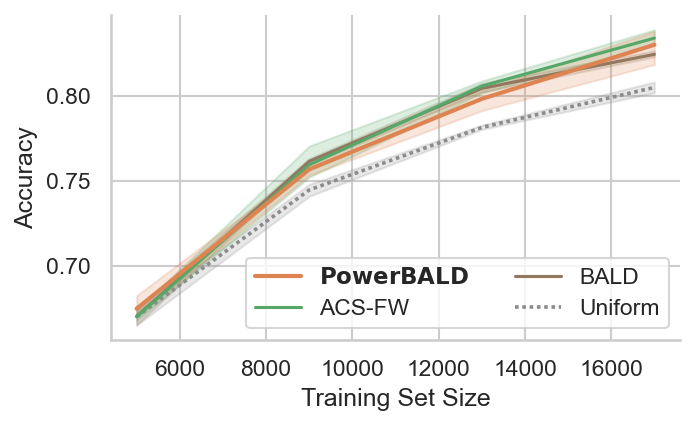

In [442]:
plot_training_set_vs_metric(abc_df[abc_df.cfg_acquisition_size==4000], "cifar10@5000", "acsfw_main", "", metric="eval_accuracy", metric_name="Accuracy")

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([2000]),
 'cfg_active_budget': array([6000]),
 'cfg_exp_type': array(['svhn@1000'], dtype=object),
 'cfg_initial_size': array([1000]),
 'cfg_label': array(['BALD Argmax (M=2000)', 'Random', 'PowerBALD Stochastic (M=2000)',
       'SoftmaxBALD Stochastic (M=2000)',
       'SoftrankBALD Stochastic (M=2000)',
       'Proj FW (M=2000, J=10, g=0.7)'], dtype=object),
 'cfg_method_name': array(['BALD', 'Uniform', '$\\bf{PowerBALD}$', '$\\bf{SoftmaxBALD}$',
       '$\\bf{SoftrankBALD}$', 'ACS-FW'], dtype=object),
 'cfg_seed': array([   1231212, 2139843534,    9438745]),
 'cfg_selection_method': array(['argmax', 'random', 'stochastic', 'fw'], dtype=object)}
Rendered to train_vs_eval_accuracy_svhn@1000_acsfw_main_None_cummax.pdf


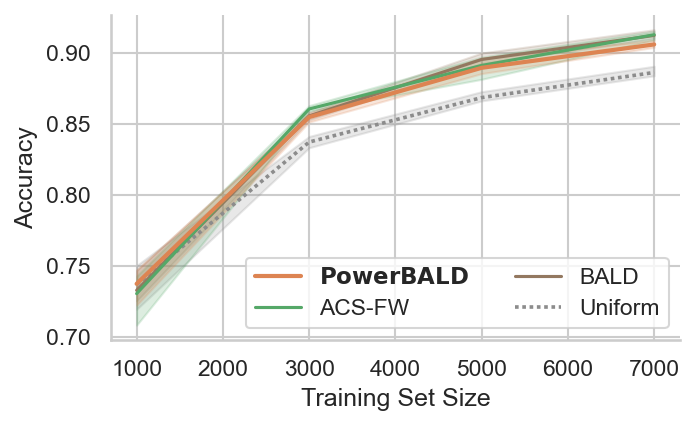

In [443]:
plot_training_set_vs_metric(abc_df[abc_df.cfg_acquisition_size==2000], "svhn@1000", "acsfw_main", "", metric="eval_accuracy", metric_name="Accuracy")

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([25]),
 'cfg_active_budget': array([200]),
 'cfg_exp_type': array(['fashion_mnist@20'], dtype=object),
 'cfg_initial_size': array([20]),
 'cfg_label': array(['BALD Argmax (M=25)', 'Random', 'PowerBALD Stochastic (M=25)',
       'SoftmaxBALD Stochastic (M=25)', 'SoftrankBALD Stochastic (M=25)',
       'Proj FW (M=25, J=10, g=0.7)'], dtype=object),
 'cfg_method_name': array(['BALD', 'Uniform', '$\\bf{PowerBALD}$', '$\\bf{SoftmaxBALD}$',
       '$\\bf{SoftrankBALD}$', 'ACS-FW'], dtype=object),
 'cfg_seed': array([   1231212, 2139843534,    9438745]),
 'cfg_selection_method': array(['argmax', 'random', 'stochastic', 'fw'], dtype=object)}
Rendered to train_vs_eval_accuracy_fashion_mnist@20_acsfw_main_None_cummax.pdf


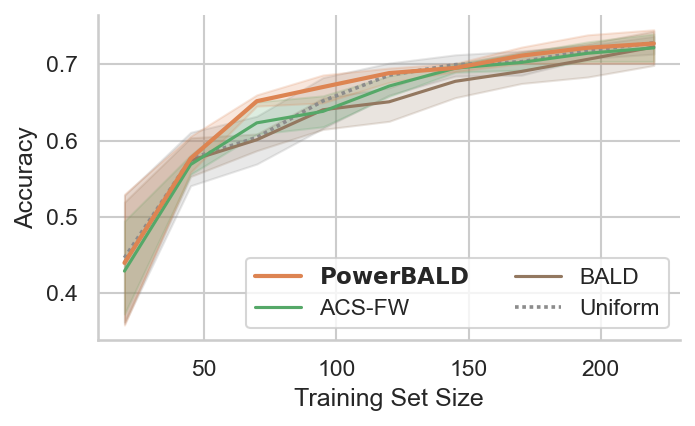

In [444]:
plot_training_set_vs_metric(abc_df[abc_df.cfg_acquisition_size==25], "fashion_mnist@20", "acsfw_main", "", metric="eval_accuracy", metric_name="Accuracy")

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([100]),
 'cfg_active_budget': array([200]),
 'cfg_exp_type': array(['repeated_mnist@20'], dtype=object),
 'cfg_initial_size': array([20]),
 'cfg_label': array(['BALD Argmax (M=100)', 'Random', 'PowerBALD Stochastic (M=100)',
       'SoftmaxBALD Stochastic (M=100)',
       'SoftrankBALD Stochastic (M=100)', 'Proj FW (M=100, J=10, g=0.7)'],
      dtype=object),
 'cfg_method_name': array(['BALD', 'Uniform', '$\\bf{PowerBALD}$', '$\\bf{SoftmaxBALD}$',
       '$\\bf{SoftrankBALD}$', 'ACS-FW'], dtype=object),
 'cfg_seed': array([   1231212, 2139843534,    9438745]),
 'cfg_selection_method': array(['argmax', 'random', 'stochastic', 'fw'], dtype=object)}
Rendered to train_vs_eval_accuracy_repeated_mnist@20_acsfw_main_None_cummax.pdf


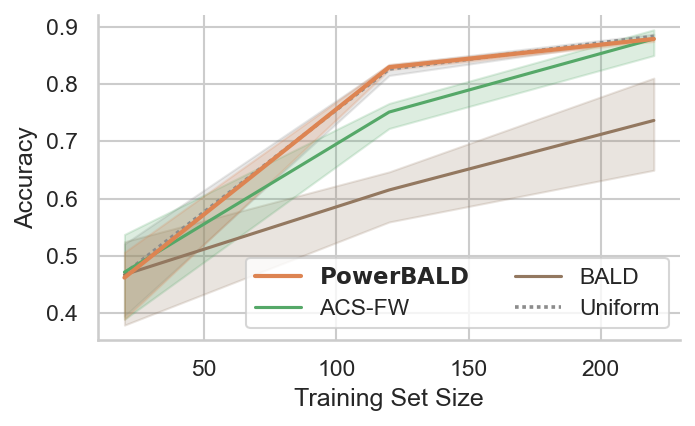

In [445]:
plot_training_set_vs_metric(abc_df[abc_df.cfg_acquisition_size==100], "repeated_mnist@20", "acsfw_main", "", metric="eval_accuracy", metric_name="Accuracy")

### Ablations

In [507]:
def plot_training_set_vs_metric_by_acquisition_size(sub_df, dataset, legend_type, path, cummax=True, max_training_set=None, verify_no_confounding=False, metric="eval_accuracy", metric_name="Accuracy", upward_metric=True):
  if dataset:
    sub_df = sub_df[sub_df.cfg_dataset == dataset]
  if all(sub_df[metric].isna()):
    print("f{metric_name} na everywhere, skipping!")
    return

  vibe_check(sub_df, verify_no_confounding)

  sub_df = sub_df.copy()
  if cummax:
    if upward_metric:
      sub_df[metric] = sub_df.groupby("exp_idx")[metric].cummax()
    else:
      sub_df[metric] = sub_df.groupby("exp_idx")[metric].cummin()

  if not isinstance(legend_type, str):
    legend_type, legend_spec = legend_type["name"], legend_type["spec"]
  else:
    legend_spec = getattr(Legends, legend_type)

  sub_df[legend_spec.hue_label] = sub_df[legend_spec.hue_key]

  sns_style_args = legend_specification_to_sns_style_args(legend_spec)

  sub_df[legend_spec.hue_label] = sub_df[legend_spec.hue_key]
  included_labels = [sm.label for sm in legend_spec.styles]
  sub_df = sub_df[sub_df[legend_spec.hue_label].isin(included_labels)]
  
  initial_size_label ="Initial Training Set Size"
  sub_df[initial_size_label] = sub_df["cfg_initial_size"]
  acquisition_size_label = "Acquisition Size"
  sub_df[acquisition_size_label] = sub_df["cfg_acquisition_size"]
  acquisition_size_order = list(sorted(sub_df[acquisition_size_label].unique()))
  
  g = sns.relplot(data=sub_df, x="training_set_size", y=metric, hue=legend_spec.hue_label, size=legend_spec.hue_label,
                  col=initial_size_label,
                  row=acquisition_size_label,
                  row_order=acquisition_size_order,
                  kind="line", facet_kws=dict(sharey=False, sharex=False),
                  style=legend_spec.hue_label,
                  **sns_style_args, height=3, aspect=1.62)
  g.set_axis_labels("Training Set Size", metric_name)
  
  # # Determine the overall xlim and ylim
  # overall_xlim = [np.inf, -np.inf]
  # overall_ylim = [np.inf, -np.inf]
  # 
  # for ax in g.axes.flat:
  #   xlim = ax.get_xlim()
  #   ylim = ax.get_ylim()
  #   overall_xlim = [min(overall_xlim[0], xlim[0]), max(overall_xlim[1], xlim[1])]
  #   overall_ylim = [min(overall_ylim[0], ylim[0]), max(overall_ylim[1], ylim[1])]
  # 
  # # Set the overall xlim and ylim for all facets
  # g.set(ylim=overall_ylim)
  
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
  g.tight_layout()
  # Invert legend order on the facet legend
  # if upward_metric:
  #   g.fig.legend(handles[::-1], labels[::-1], ncol=2)
  # else:
  #   g.fig.legend(handles[::-1], labels[::-1], ncol=2)
  # Extract handlers and labels from the facet legend
  for ax in g.axes.flat:
    g._update_legend_data(ax)
  g._legend.remove()
  g.add_legend(label_order=included_labels)
  
  output_name = f"{path}train_vs_{metric}_{dataset}_{legend_type}_{max_training_set}"
  if cummax:
    output_name += "_cummax"
  else:
    output_name += "_raw"
  output_name += ".pdf"
  savefig(g, output_name)
  print("Rendered to", output_name)
  plt.show()

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([1000,  125, 2000,  250, 4000,  500,   75]),
 'cfg_active_budget': array([16000, 12000]),
 'cfg_dataset': array(['cifar10'], dtype=object),
 'cfg_exp_type': array(['cifar10@1000', 'cifar10@5000'], dtype=object),
 'cfg_initial_size': array([1000, 5000]),
 'cfg_label': array(['BALD Argmax (M=1000)', 'BALD Argmax (M=125)',
       'BALD Argmax (M=2000)', 'BALD Argmax (M=250)',
       'BALD Argmax (M=4000)', 'BALD Argmax (M=500)',
       'BALD Argmax (M=75)', 'Random', 'PowerBALD Stochastic (M=1000)',
       'PowerBALD Stochastic (M=125)', 'PowerBALD Stochastic (M=2000)',
       'PowerBALD Stochastic (M=250)', 'PowerBALD Stochastic (M=4000)',
       'PowerBALD Stochastic (M=500)', 'PowerBALD Stochastic (M=75)',
       'SoftmaxBALD Stochastic (M=1000)',
       'SoftmaxBALD Stochastic (M=125)',
       'SoftmaxBALD Stochastic (M=2000)',
  

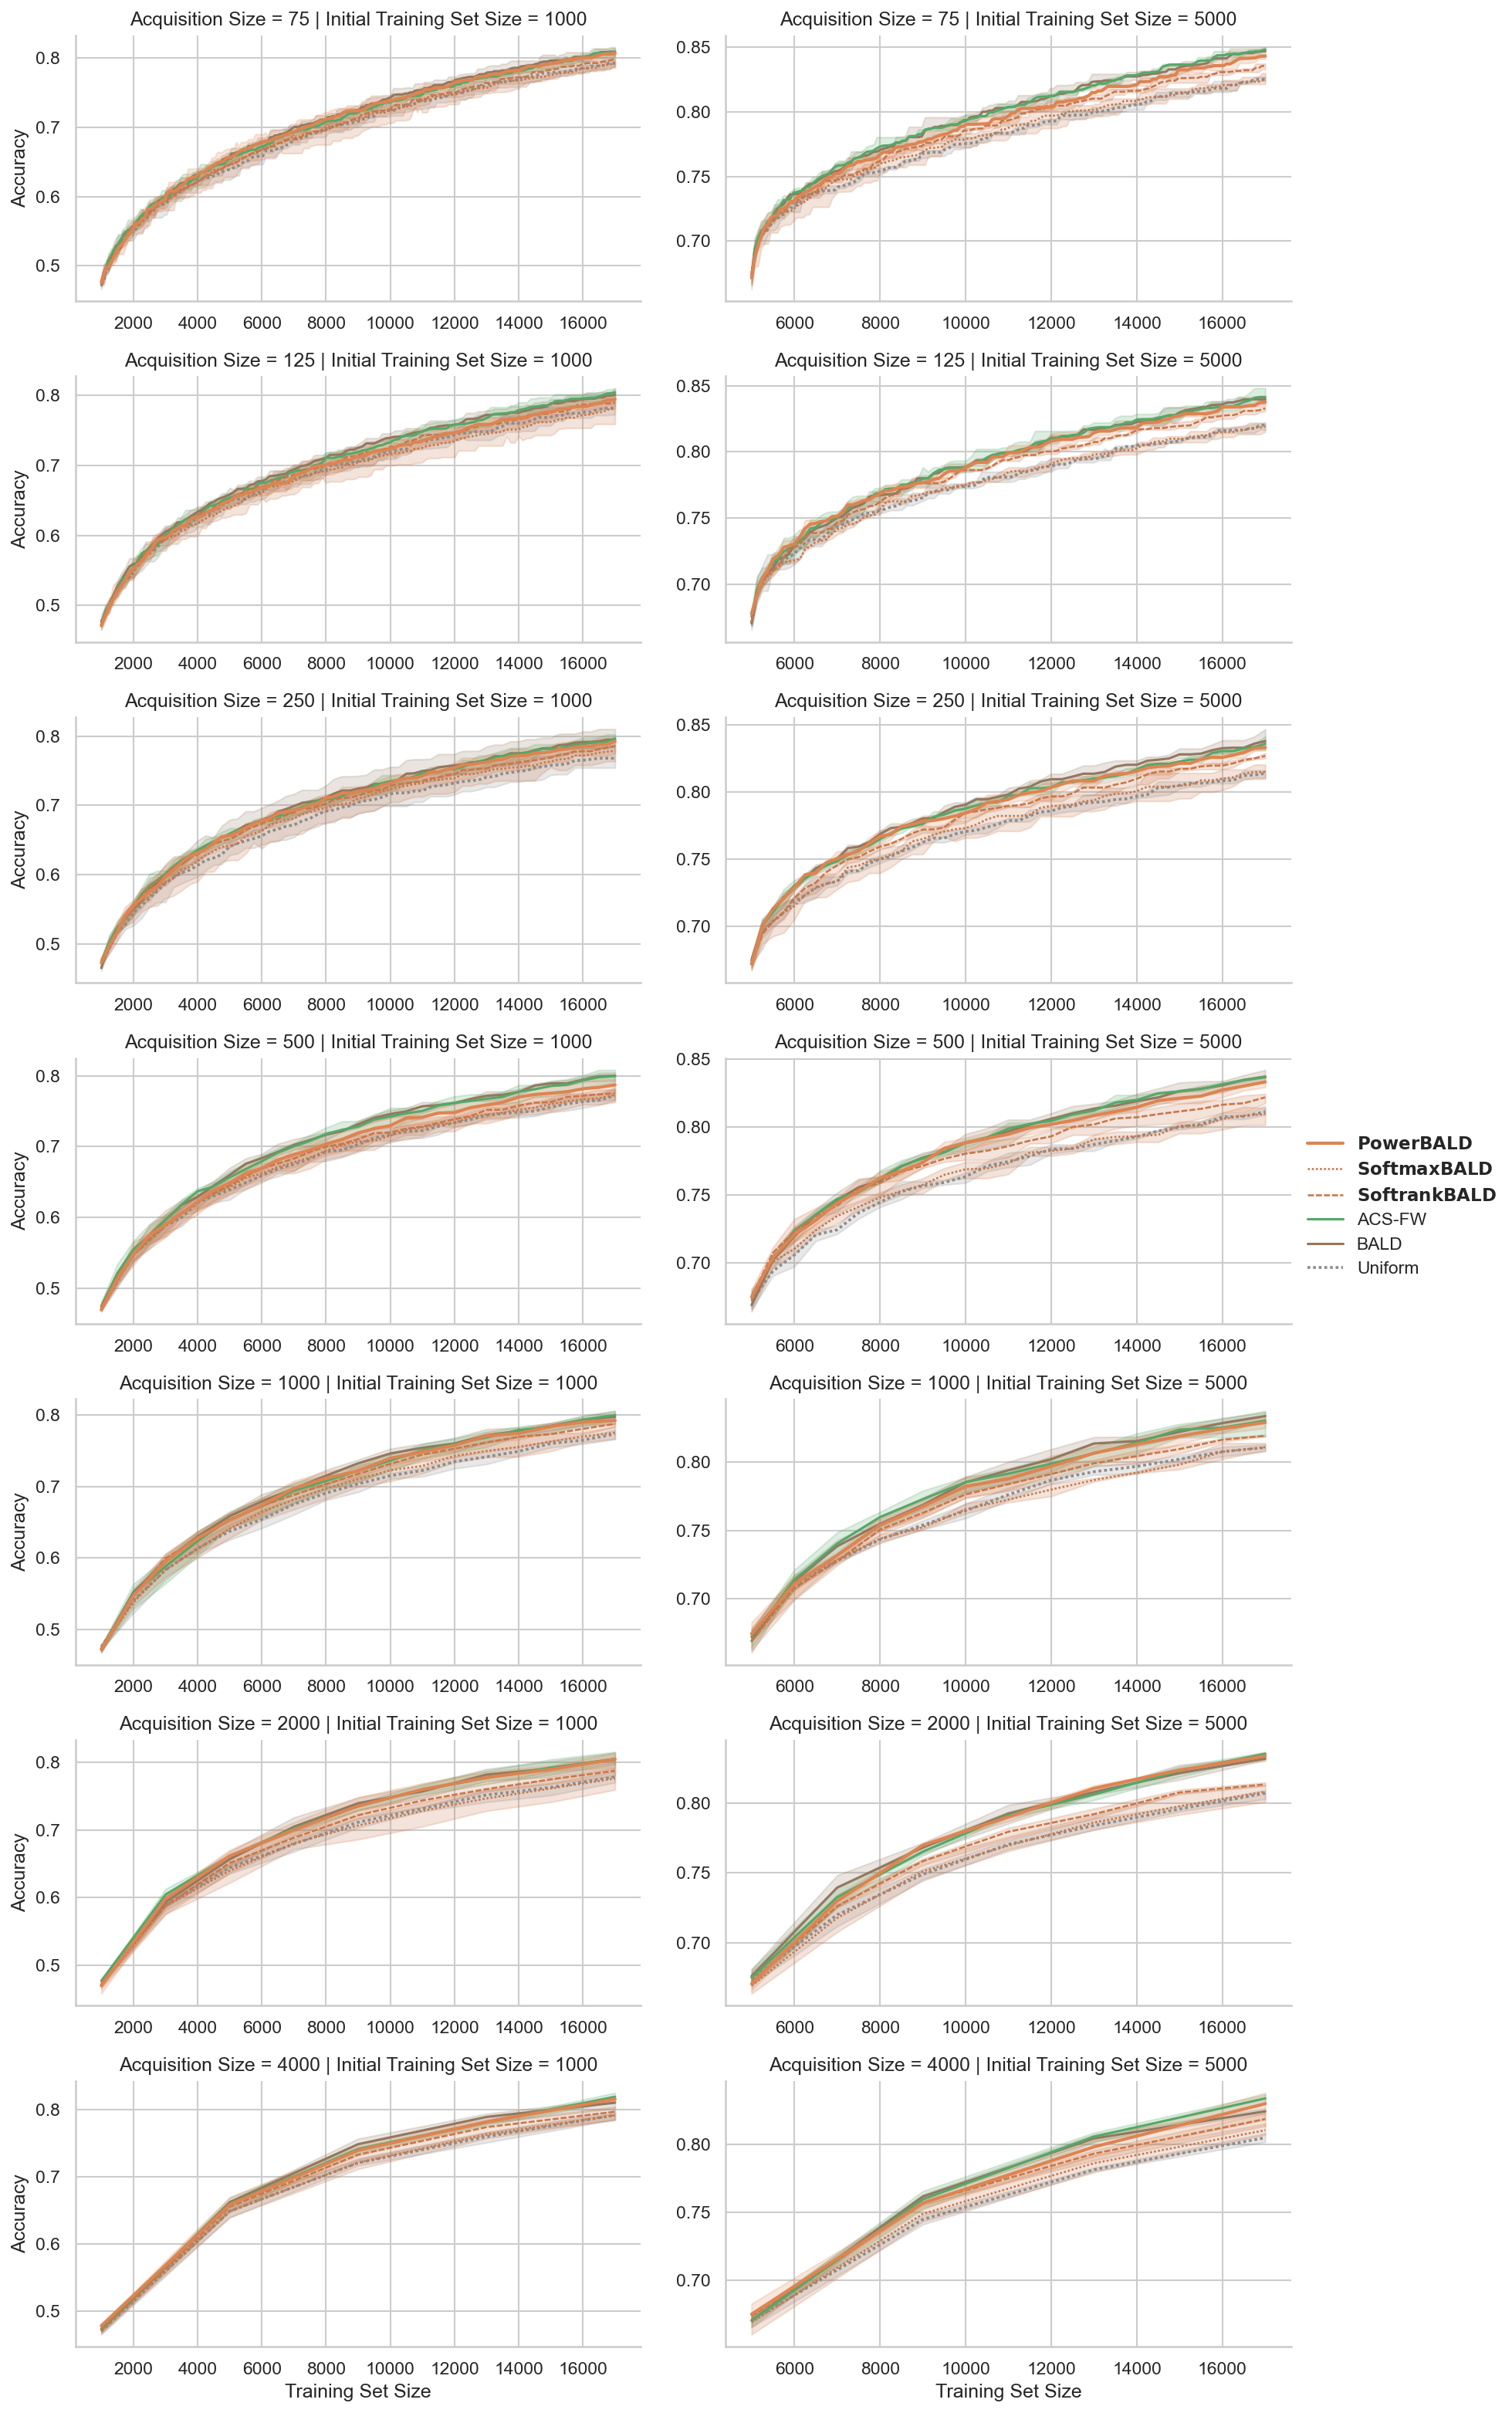

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([1000,  125, 2000,  250,  500,   75]),
 'cfg_active_budget': array([6000, 4000]),
 'cfg_dataset': array(['svhn'], dtype=object),
 'cfg_exp_type': array(['svhn@1000', 'svhn@3000'], dtype=object),
 'cfg_initial_size': array([1000, 3000]),
 'cfg_label': array(['BALD Argmax (M=1000)', 'BALD Argmax (M=125)',
       'BALD Argmax (M=2000)', 'BALD Argmax (M=250)',
       'BALD Argmax (M=500)', 'BALD Argmax (M=75)', 'Random',
       'PowerBALD Stochastic (M=1000)', 'PowerBALD Stochastic (M=125)',
       'PowerBALD Stochastic (M=2000)', 'PowerBALD Stochastic (M=250)',
       'PowerBALD Stochastic (M=500)', 'PowerBALD Stochastic (M=75)',
       'SoftmaxBALD Stochastic (M=1000)',
       'SoftmaxBALD Stochastic (M=125)',
       'SoftmaxBALD Stochastic (M=2000)',
       'SoftmaxBALD Stochastic (M=250)', 'SoftmaxBALD Stochastic (M=500)',
       '

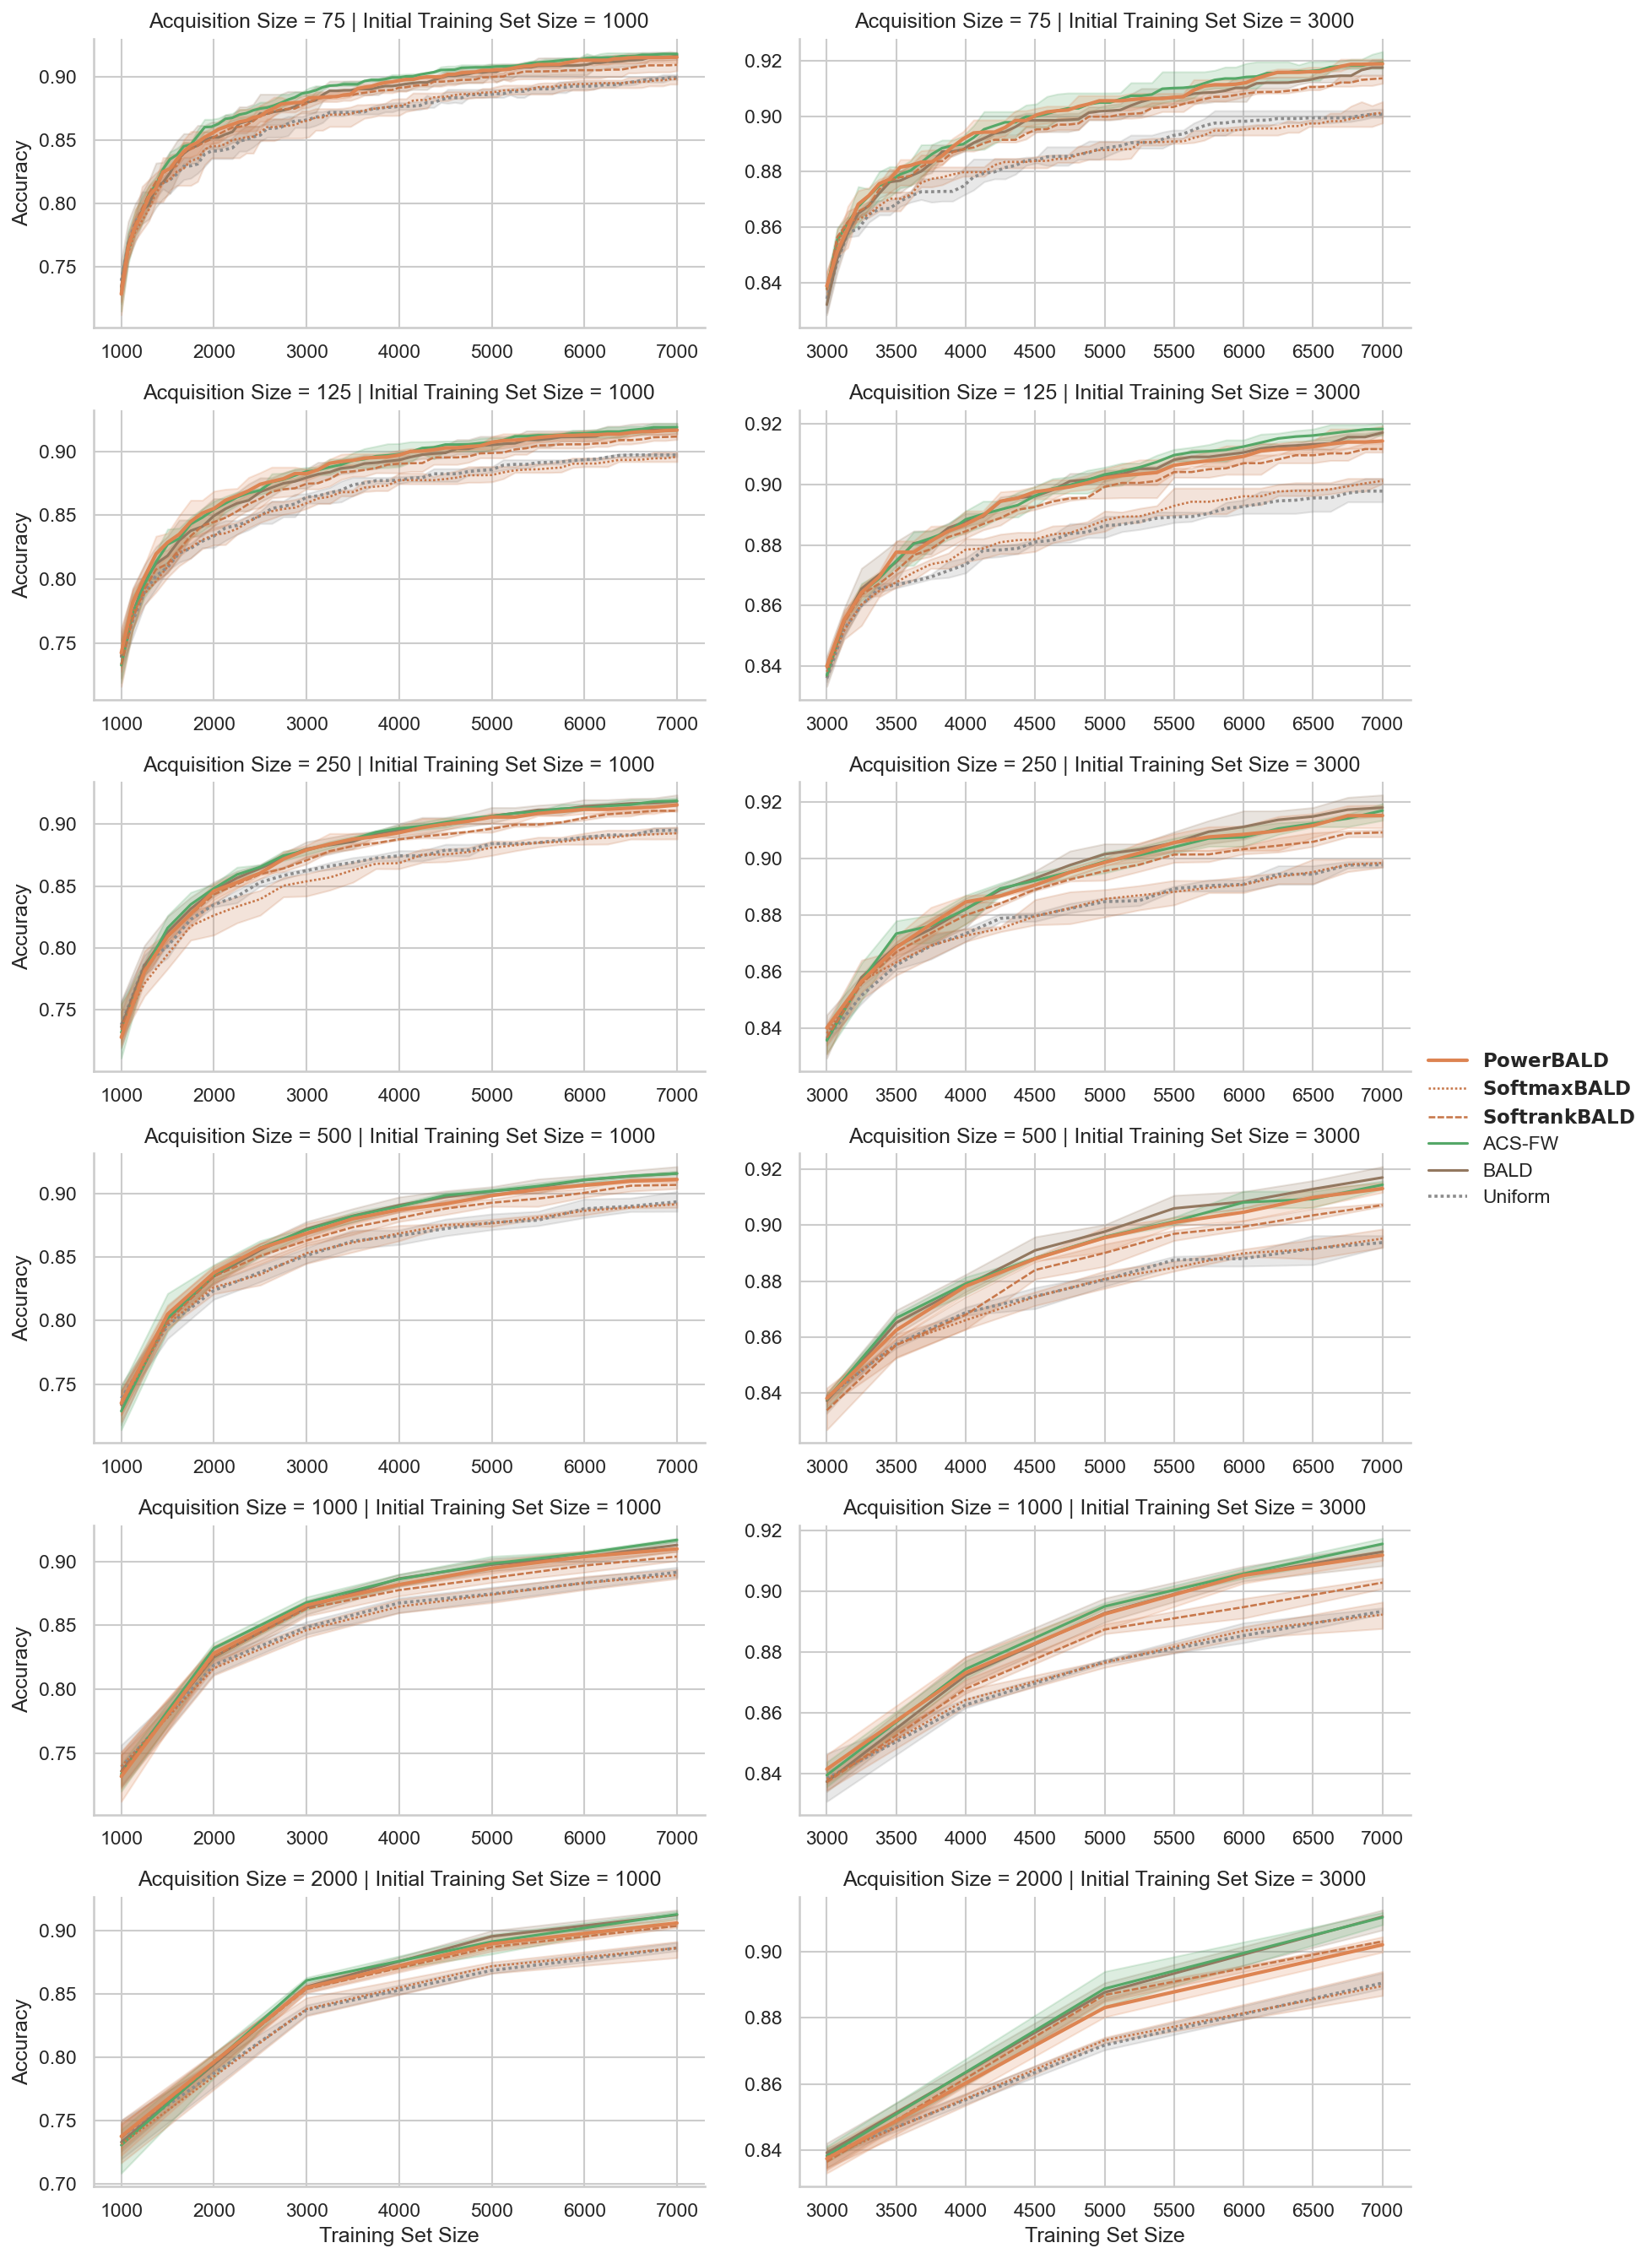

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([100,  25,  50]),
 'cfg_active_budget': array([200]),
 'cfg_dataset': array(['fashion_mnist'], dtype=object),
 'cfg_exp_type': array(['fashion_mnist@100', 'fashion_mnist@20'], dtype=object),
 'cfg_initial_size': array([100,  20]),
 'cfg_label': array(['BALD Argmax (M=100)', 'BALD Argmax (M=25)', 'BALD Argmax (M=50)',
       'Random', 'PowerBALD Stochastic (M=100)',
       'PowerBALD Stochastic (M=25)', 'PowerBALD Stochastic (M=50)',
       'SoftmaxBALD Stochastic (M=100)', 'SoftmaxBALD Stochastic (M=25)',
       'SoftmaxBALD Stochastic (M=50)', 'SoftrankBALD Stochastic (M=100)',
       'SoftrankBALD Stochastic (M=25)', 'SoftrankBALD Stochastic (M=50)',
       'Proj FW (M=100, J=10, g=0.7)', 'Proj FW (M=25, J=10, g=0.7)',
       'Proj FW (M=50, J=10, g=0.7)'], dtype=object),
 'cfg_method_name': array(['BALD', 'Uniform', '$\\bf{Power

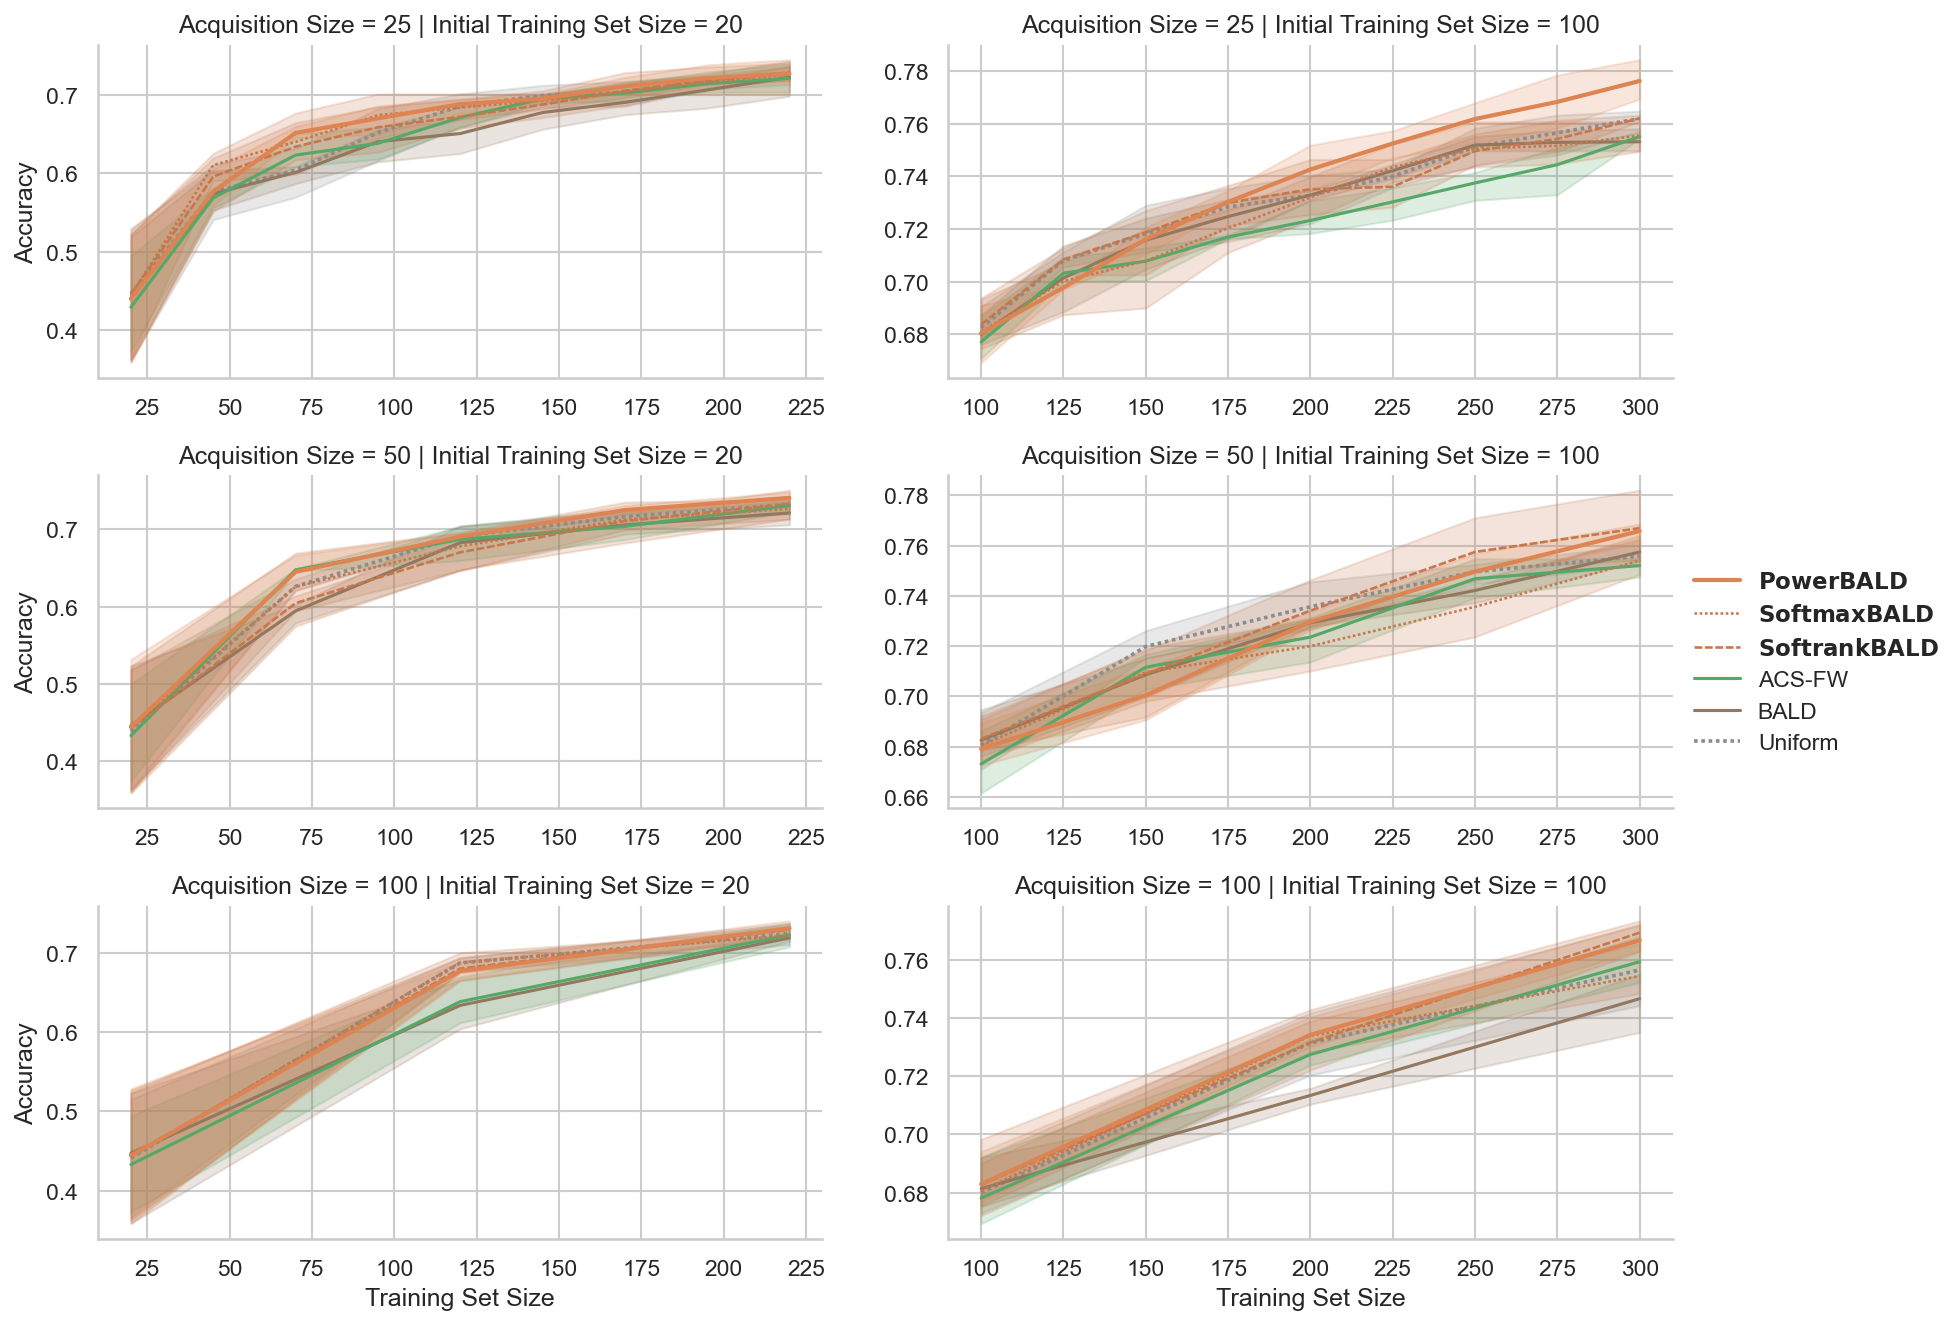

{'cfg_acquisition_function': array(['bald', 'none', 'powerbald', 'softmaxbald', 'softrankbald', 'proj'],
      dtype=object),
 'cfg_acquisition_size': array([100,  25,  50]),
 'cfg_active_budget': array([200]),
 'cfg_dataset': array(['repeated_mnist'], dtype=object),
 'cfg_exp_type': array(['repeated_mnist@100', 'repeated_mnist@20'], dtype=object),
 'cfg_initial_size': array([100,  20]),
 'cfg_label': array(['BALD Argmax (M=100)', 'BALD Argmax (M=25)', 'BALD Argmax (M=50)',
       'Random', 'PowerBALD Stochastic (M=100)',
       'PowerBALD Stochastic (M=25)', 'PowerBALD Stochastic (M=50)',
       'SoftmaxBALD Stochastic (M=100)', 'SoftmaxBALD Stochastic (M=25)',
       'SoftmaxBALD Stochastic (M=50)', 'SoftrankBALD Stochastic (M=100)',
       'SoftrankBALD Stochastic (M=25)', 'SoftrankBALD Stochastic (M=50)',
       'Proj FW (M=100, J=10, g=0.7)', 'Proj FW (M=25, J=10, g=0.7)',
       'Proj FW (M=50, J=10, g=0.7)'], dtype=object),
 'cfg_method_name': array(['BALD', 'Uniform', '$\\bf{Po

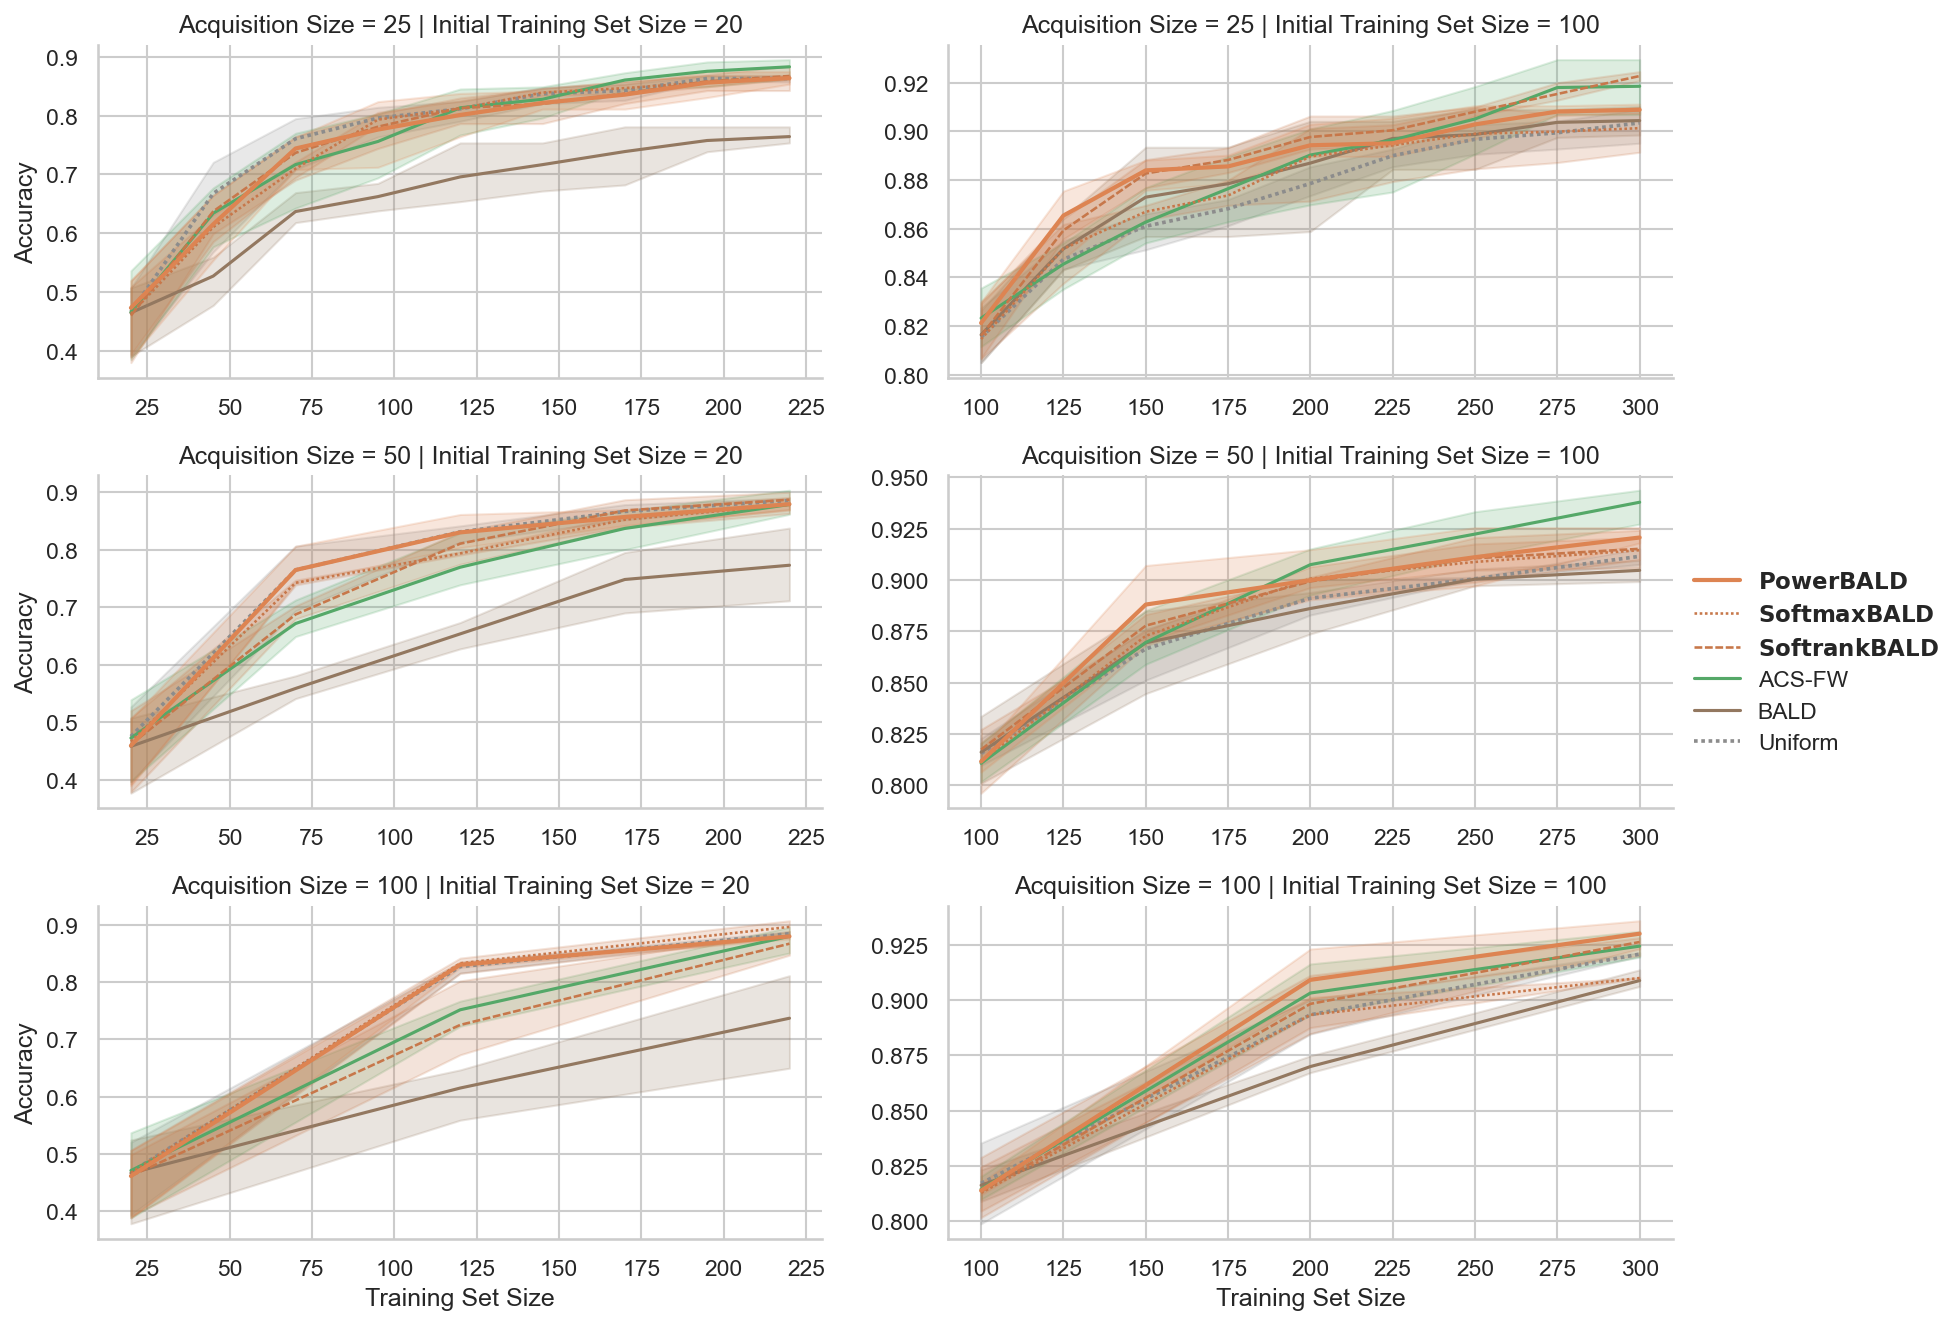

In [508]:
plot_training_set_vs_metric_by_acquisition_size(abc_df, "cifar10", "acsfw_ablation", "", metric="eval_accuracy", metric_name="Accuracy")
plot_training_set_vs_metric_by_acquisition_size(abc_df, "svhn", "acsfw_ablation", "", metric="eval_accuracy", metric_name="Accuracy")
plot_training_set_vs_metric_by_acquisition_size(abc_df, "fashion_mnist", "acsfw_ablation", "", metric="eval_accuracy", metric_name="Accuracy")
plot_training_set_vs_metric_by_acquisition_size(abc_df, "repeated_mnist", "acsfw_ablation", "", metric="eval_accuracy", metric_name="Accuracy")